<a id='top'></a>

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# %matplotlib nbagg 
%matplotlib notebook
# %matplotlib inline



## Third party 
import numpy as np
import os, time, zarr, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import unslice.IO as io
from unslice.utils import *
from unslice.registration.featmatch import *
from unslice.registration.transform import *
from unslice.registration.rigid import *
from unslice.registration.gpu_transform import *
from unslice.registration.utils import *
from unslice.segmentation import *
from unslice.tracing.pyoof import OOF, apply_oof_v2
from unslice.tracing.skel import *
from unslice.flatten import *
from unslice.lightsheetcorrect import *




In [5]:
# Parameters that are constant throughout notebook
working_dir = '/mnt/share3/webster/MORF8_3and4/MORF8_3and4'

def bdir(fname):
    return os.path.join(working_dir, fname)

# prefix to add to the beginning of each filename 
name_prefix = 'L-lec' #left
name_prefix2 = 'R-lec' #right

### Bottom of left ("top") goes with top of right ("bottom")

# Table of contents

### Pre-processing
[1. Convert to zarr](#convert)<br>
[2. Downsample](#downsample)<br>
[3. Segment](#segment)<br>
[4. Surface detection](#surfdetect)<br>
[5. Background correction](#background)<br>

### Endpoint detection
[5. Vessel filter](#oof)<br>
[6. Vessel segment](#vessel_segment)<br>
[7. Vessel skeletonization](#skel)<br>
[8. Vessel endpoint detection](#epdetect)<br>

### Surface flattening 
[9. Sample surface](#flatten)<br>
[10. Surface outlier removal](#outlier_surf)<br>
[10a. Make surface mask for vessel endpoints](#create_mask)<br>
[11. UV map](#uvmap)<br>
[12. Rigid align UV maps](#uvuvalign)<br>
[13. Flatten warp](#flattenwarp)<br>
[14. Flatten warp anchor points, detected points](#pointflatten)<br>

### Transformation
[14. Rigid transformation based on manual anchor points](#rigidanchor)<br>
[15. TPS transformation based on manual anchor points (round 0)](#anchorwarp)<br>
[16. Feature match (round 0)](#featmatch)<br>
[17. TPS transformation (Round 1)](#tpswarp)<br>
[18. Warp anchor pts and endpoints to R1 frame](#warp_points_r1)<br>
[19. Redo feature match (round 1)](#feature_match_r1)<br>
[20. TPS Transformation (round 2)](#tpswarp_r2)<br>
[21. Warp anchor pts and endpoints to R2 frame](#warp_points_r2)<br>
[22. Round 3](#tpswarp_r3)<br>

# Convert to zarr
<a id='convert'></a>

[Return to top](#top)

In [3]:
# Parameters for converting to zarr

# left

slab_path = '/mnt/cephfs/general/juhyuk/paper_data/20220626_13_13_29_80-3and4/Ex_488_Em_1_destriped_stitched'
slab_zarr_path = bdir(name_prefix+'.zarr')
pc2_img_size = (15411,3891,2054)


## Optional parameters 
load_num_slices = 40 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (1,1) # original is (1,231 x 1,74 x 1,231)
chunks = (200,200,200) 
num_workers = 20 
file_names = 'img_[0-9]{4}.jp2' # default 'img_[0-9]{4}.tiff'

## crop
zrange = [680,1080] # default None
xrange = [3000,6900] # default None
yrange = [400,3800] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

Processing chunk x:3000-6900, y:400-3800, z:680-720


100%|██████████| 40/40 [00:03<00:00, 11.20it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [00:36<00:00,  9.42it/s]

Processing chunk x:3000-6900, y:400-3800, z:720-760



100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:35<00:00,  9.64it/s]


Processing chunk x:3000-6900, y:400-3800, z:760-800


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:36<00:00,  9.25it/s]


Processing chunk x:3000-6900, y:400-3800, z:800-840


100%|██████████| 40/40 [00:03<00:00, 10.36it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:39<00:00,  8.54it/s]


Processing chunk x:3000-6900, y:400-3800, z:840-880


100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:46<00:00,  7.35it/s]


Processing chunk x:3000-6900, y:400-3800, z:880-920


100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [01:10<00:00,  4.83it/s]


Processing chunk x:3000-6900, y:400-3800, z:920-960


100%|██████████| 40/40 [00:04<00:00,  8.71it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [01:01<00:00,  5.55it/s]

Processing chunk x:3000-6900, y:400-3800, z:960-1000



100%|██████████| 40/40 [00:04<00:00,  9.07it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [01:09<00:00,  4.88it/s]

Processing chunk x:3000-6900, y:400-3800, z:1000-1040



100%|██████████| 40/40 [00:03<00:00, 10.32it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [01:16<00:00,  4.46it/s]

Processing chunk x:3000-6900, y:400-3800, z:1040-1080



100%|██████████| 40/40 [00:03<00:00, 12.04it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [01:18<00:00,  4.36it/s]


596.4819457530975 seconds elapsed


In [3]:
# Parameters for converting to zarr

# Right

slab_path = '/mnt/cephfs/general/juhyuk/paper_data/MORF8_3and4/Ex_488_Em_1_destriped_stitched'
slab_zarr_path = bdir(name_prefix2+'.zarr')
pc2_img_size = (15411,3891,2054)


## Optional parameters 
load_num_slices = 40 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (1,1) # original is (1,231 x 1,74 x 1,231)
chunks = (200,200,200) 
num_workers = 20 
file_names = 'img_[0-9]{4}.jp2' # default 'img_[0-9]{4}.tiff'

## crop
zrange = [700,1060] # default None
xrange = [9150,13050] # default None
yrange = [600,3850] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

Processing chunk x:9150-13050, y:600-3850, z:700-740


100%|██████████| 40/40 [00:03<00:00, 12.53it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [00:01<00:00, 196.74it/s]


Processing chunk x:9150-13050, y:600-3850, z:740-780


100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:03<00:00, 98.83it/s] 


Processing chunk x:9150-13050, y:600-3850, z:780-820


100%|██████████| 40/40 [00:03<00:00, 11.04it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:06<00:00, 51.25it/s]


Processing chunk x:9150-13050, y:600-3850, z:820-860


100%|██████████| 40/40 [00:04<00:00,  9.78it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:12<00:00, 26.80it/s]

Processing chunk x:9150-13050, y:600-3850, z:860-900



100%|██████████| 40/40 [00:04<00:00,  8.89it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:20<00:00, 16.66it/s]


Processing chunk x:9150-13050, y:600-3850, z:900-940


100%|██████████| 40/40 [00:05<00:00,  7.24it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:06<00:00, 50.31it/s]


Processing chunk x:9150-13050, y:600-3850, z:940-980


100%|██████████| 40/40 [00:04<00:00,  8.79it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 340/340 [00:17<00:00, 19.48it/s]


Processing chunk x:9150-13050, y:600-3850, z:980-1020


100%|██████████| 40/40 [00:03<00:00, 10.28it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [00:21<00:00, 15.48it/s]

Processing chunk x:9150-13050, y:600-3850, z:1020-1060



100%|██████████| 40/40 [00:03<00:00, 12.15it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 340/340 [00:22<00:00, 15.28it/s]


155.03968977928162 seconds elapsed


# Downsample 

<a id='downsample'></a>

[Return to top](#top)

In [5]:
# Parameters for converting to zarr

# left

slab_path = '/mnt/cephfs/general/juhyuk/paper_data/20220626_13_13_29_80-3and4/Ex_488_Em_1_destriped_stitched'
slab_zarr_path = bdir(name_prefix+'_downsampled.zarr')
pc2_img_size = (15411,3891,2054)


## Optional parameters 
load_num_slices = 40 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (0.1,0.1) # original is (1,231 x 1,74 x 1,231)
chunks = (200,200,200) 
num_workers = 20 
file_names = 'img_[0-9]{4}.jp2' # default 'img_[0-9]{4}.tiff'

## crop
zrange = [680,1080] # default None
xrange = [3000,6900] # default None
yrange = [400,3800] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

z = zarr.open(slab_zarr_path,mode='r')
io.writeData(slab_zarr_path[:-5]+'.tif', z[:])

Processing chunk x:3000-6900, y:400-3800, z:680-720


100%|██████████| 40/40 [00:01<00:00, 22.71it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 11.78it/s]

Processing chunk x:3000-6900, y:400-3800, z:720-760



100%|██████████| 40/40 [00:01<00:00, 22.50it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 10.46it/s]

Processing chunk x:3000-6900, y:400-3800, z:760-800



100%|██████████| 40/40 [00:02<00:00, 19.26it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00,  9.24it/s]

Processing chunk x:3000-6900, y:400-3800, z:800-840



100%|██████████| 40/40 [00:02<00:00, 14.18it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

Processing chunk x:3000-6900, y:400-3800, z:840-880



100%|██████████| 40/40 [00:03<00:00, 10.44it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

Processing chunk x:3000-6900, y:400-3800, z:880-920



100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

Processing chunk x:3000-6900, y:400-3800, z:920-960



100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

Processing chunk x:3000-6900, y:400-3800, z:960-1000



100%|██████████| 40/40 [00:03<00:00, 11.88it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

Processing chunk x:3000-6900, y:400-3800, z:1000-1040



100%|██████████| 40/40 [00:02<00:00, 16.19it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

Processing chunk x:3000-6900, y:400-3800, z:1040-1080



100%|██████████| 40/40 [00:01<00:00, 21.28it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


39.768290996551514 seconds elapsed


'/mnt/share7/webster/MORF8_3and4/L-lec_downsampled.tif'

In [4]:
# Parameters for converting to zarr

# Right

slab_path = '/mnt/cephfs/general/juhyuk/paper_data/MORF8_3and4/Ex_488_Em_1_destriped_stitched'
slab_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
pc2_img_size = (15411,3891,2054)


## Optional parameters 
load_num_slices = 40 # should be smaller than z chunk size, default None 
resample_num_slices = 1 # number of slices to be processed in one go for resampling, default 1
resample_factor = (.1,.1) # original is (1,231 x 1,74 x 1,231)
chunks = (200,200,200) 
num_workers = 20 
file_names = 'img_[0-9]{4}.jp2' # default 'img_[0-9]{4}.tiff'

## crop
zrange = [700,1060] # default None
xrange = [9150,13050] # default None
yrange = [600,3850] # default None

## rotate
lateral_rotate_angle = None # default None

## flip
flip = (0,0,0) # default (0,0,0)


#############
start = time.time()
utils.convert_to_zarr_v2(slab_path, slab_zarr_path, pc2_img_size, load_num_slices=load_num_slices,
                        resample_num_slices=resample_num_slices, file_names=file_names, 
                        chunks=chunks, num_workers=num_workers, lateral_rotate_angle=lateral_rotate_angle,
                        flip=flip, crop_xcoords=xrange, crop_ycoords=yrange, crop_zcoords=zrange,
                        resample_factor=resample_factor)
print(time.time()-start, 'seconds elapsed')

z = zarr.open(slab_zarr_path,mode='r')
io.writeData(slab_zarr_path[:-5]+'.tif', z[:])

Processing chunk x:9150-13050, y:600-3850, z:700-740


100%|██████████| 40/40 [00:01<00:00, 23.70it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 77.50it/s]

Processing chunk x:9150-13050, y:600-3850, z:740-780



100%|██████████| 40/40 [00:01<00:00, 23.32it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00, 35.48it/s]


Processing chunk x:9150-13050, y:600-3850, z:780-820


100%|██████████| 40/40 [00:02<00:00, 19.21it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00, 24.77it/s]


Processing chunk x:9150-13050, y:600-3850, z:820-860


100%|██████████| 40/40 [00:02<00:00, 14.63it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 18.46it/s]

Processing chunk x:9150-13050, y:600-3850, z:860-900



100%|██████████| 40/40 [00:03<00:00, 10.65it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 12.28it/s]

Processing chunk x:9150-13050, y:600-3850, z:900-940



100%|██████████| 40/40 [00:03<00:00, 10.48it/s]

Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...



100%|██████████| 4/4 [00:00<00:00, 35.13it/s]


Processing chunk x:9150-13050, y:600-3850, z:940-980


100%|██████████| 40/40 [00:03<00:00, 12.51it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00, 18.17it/s]

Processing chunk x:9150-13050, y:600-3850, z:980-1020



100%|██████████| 40/40 [00:02<00:00, 16.45it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00, 14.31it/s]

Processing chunk x:9150-13050, y:600-3850, z:1020-1060



100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Data I/O, resampling, rotation complete. Commencing flip and zarr assignment...


100%|██████████| 4/4 [00:00<00:00, 12.45it/s]

29.94946551322937 seconds elapsed


In [19]:
slab_zarr_path = bdir(name_prefix2+'_downsampled.zarr')
z = zarr.open(slab_zarr_path,mode='r')
io.writeData(slab_zarr_path[:-5]+'.tif', z[:])

'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/R-lec_downsampled.tif'

# Surface detection

## Tissue segmentation
<a id='segment'></a>
[Return to top](#top)

### Left == top

In [13]:
# Parameters to be varied
sample_coord_ranges = [[[0,390],[0,340],[0,400]]]
min_thresholds = [175,200]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [400,400] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [14]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix+'_downsampled.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.014269 minutes


100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh175-400_x0_390_y0_340_z0_400_original.tif original red /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh175-400_x0_390_y0_340_z0_400_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.431823 minutes
Starting image preprocessing..
Saturated image processed in 0.017296 minutes


100%|██████████| 8/8 [00:25<00:00,  3.17s/it]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh200-400_x0_390_y0_340_z0_400_original.tif original red /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh200-400_x0_390_y0_340_z0_400_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.495202 minutes


In [15]:
opts = {
    'min_threshold' : 180, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 400,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, # ('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix+'_downsampled.zarr')
zarr_segmented_path = bdir(name_prefix+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.012541 minutes


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]

Time elapsed: 0.385305 minutes


### Right == bottom

In [5]:
# Bottom
# Parameters to be varied
sample_coord_ranges = [[[0,390],[0,325],[0,350]]]
min_thresholds = [150,200]#*3 # gets rid of background. Pick more or less stringent ones 
saturate_image_thresholds = [400,400] # saturate image threshold
morphopts = [None]*2 #[('close','ball',2)]*3

In [17]:
for i in range(len(min_thresholds)):
    opts = {
        'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels, choose this so that most background that is not tissue is eliminated
        'saturate_image_threshold' : saturate_image_thresholds[i], # if <1, then is a percent of pixels to saturate 
        'k' : 2,
        'alpha' : 25, # make this very high for high smoothness 
        'num_workers' : 24,
        'overlap' : 0,
        'morphopts' : morphopts[i],
        'sample_coord_ranges' :  sample_coord_ranges # Change this if we want to sample a few slices and see if it's worth processing whole data set on that 
        }
    zarr_path = bdir(name_prefix2+'_downsampled.zarr')
    zarr_segmented_path = bdir('surf_segmentation_tests/segmenttest.zarr')

    start = time.time()
    zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
    print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.012149 minutes


100%|██████████| 8/8 [00:25<00:00,  3.17s/it]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh150-400_x0_390_y0_325_z0_350_original.tif original red /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh150-400_x0_390_y0_325_z0_350_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.483408 minutes
Starting image preprocessing..
Saturated image processed in 0.015865 minutes


100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


Display in Nuggt by doing !{cmd}: 
nuggt-display /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh200-400_x0_390_y0_325_z0_350_original.tif original red /mnt/share7/webster/MORF8_3and4/surf_segmentation_tests/segmenttest_thresh200-400_x0_390_y0_325_z0_350_segmented.tif segged green --ip-address 10.93.6.101 --port=8900
Time elapsed: 0.416562 minutes


In [6]:
opts = {
    'min_threshold' : 180, # This sets a minimum intensity threshold for pixels 
    'saturate_image_threshold' : 400,
    'k' : 2,
    'alpha' : 25,
    'num_workers' : 24,
    'overlap' : 0,
    'morphopts' : None, #('dilate','ball',2),
    'sample_coord_ranges' : None
    }
zarr_path = bdir(name_prefix2+'_downsampled.zarr')
zarr_segmented_path = bdir(name_prefix2+'_downsampled_segmented.zarr')

start = time.time()
zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

Starting image preprocessing..
Saturated image processed in 0.009888 minutes


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]

Time elapsed: 0.350901 minutes


# Surface detection

<a id='surfdetect'></a>

[Return to top](#top)

### Top

In [65]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_top.zarr')
slices_to_search = [4,230]
num_slices_to_add = 15 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

100%|██████████| 226/226 [00:00<00:00, 274.58it/s]


Time elapsed: 0.025733 minutes


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/L-lec_downsampled_surface_top.tif'

In [67]:
# Find the bottom
segmented_zarr_path = bdir(name_prefix+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom.zarr')
slices_to_search = [165,395]
num_slices_to_add = 15 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

100%|██████████| 230/230 [00:00<00:00, 274.84it/s]


Time elapsed: 0.018742 minutes


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/L-lec_downsampled_surface_bottom.tif'

### Bottom

In [7]:
# Find the top surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
slices_to_search = [10,190]
num_slices_to_add = 15 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'ztop'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

100%|██████████| 180/180 [00:00<00:00, 245.59it/s]


Time elapsed: 0.020816 minutes


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/R-lec_downsampled_surface_top.tif'

In [8]:
# Find the bottom surface 
segmented_zarr_path = bdir(name_prefix2+'_downsampled_segmented.zarr')
surf_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom.zarr')
slices_to_search = [140,350]
num_slices_to_add = 15 # make low if we're just sampling points on the surface 
num_slices_above = False # if True, then add in pixels above surface to check for endpoints 
orientation = 'zbottom'
use_full_image = True
thin_surf_zarr_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')# default None, need a path here if we want to do new method 



#########
start = time.time()
mask2surf_zarr(segmented_zarr_path, surf_zarr_path, slices_to_search,
               num_slices_to_add, num_slices_above, orientation=orientation, use_full_image=use_full_image,
              thin_surf_zarr_path=thin_surf_zarr_path)
print("Time elapsed: %f minutes"%((time.time()-start)/60))

z = zarr.open(surf_zarr_path,mode='r')
io.writeData(surf_zarr_path[:-4]+'tif', z[:])

100%|██████████| 210/210 [00:00<00:00, 271.16it/s]


Time elapsed: 0.019523 minutes


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/R-lec_downsampled_surface_bottom.tif'

# Background correction

[Return to top](#top)

<a id='background'></a>

In [23]:
source_zarr_path = bdir(name_prefix+'.zarr')
sink_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
num_workers = 40

background_correct_args = {'percentile': 0.25,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

Working on z=0 to 200


100%|██████████| 200/200 [00:18<00:00, 10.82it/s]


Working on z=200 to 400


100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


Time elapsed: 260.1353557109833 seconds


In [28]:
# Check the quality
check = True

if check:
    xr = [1500,2500]
    yr = [1500,2500]
    zr = [200,400]
    save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
    save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


    #####
    z = zarr.open(bdir(name_prefix+'_illumcorr.zarr'), mode='r')
    io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])
    
    z = zarr.open(bdir(name_prefix+'.zarr'), mode='r')
    io.writeData(save_path_og, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

In [10]:
# source_zarr_path = bdir(name_prefix+'_illumcorr.zarr')
# sink_zarr_path = bdir(name_prefix+'_illumcorr_r2.zarr')
# num_workers = 40

# background_correct_args = {'percentile': 0.25,
#           'background': dict(selem=(60,60,1)),
#           'factor': 1.5
#           }



# ######################
# # parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
# #                       num_workers=num_workers, **background_correct_args)
# start = time.time()
# parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
# print("Time elapsed:",time.time()-start,"seconds")

# # Check the quality
# check = True

# if check:
#     xr = [0,3360]
#     yr = [0,2910]
#     zr = [350,650]
#     save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr_r2.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
#     #save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


#     #####
#     z = zarr.open(bdir(name_prefix+'_illumcorr_r2.zarr'), mode='r')
#     io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

Working on z=0 to 200


100%|██████████| 200/200 [00:14<00:00, 14.17it/s]


Working on z=200 to 400


100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


Working on z=400 to 600


100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


Working on z=600 to 650


100%|██████████| 50/50 [00:04<00:00, 12.00it/s]


Time elapsed: 311.85470366477966 seconds


### Bottom

In [9]:
source_zarr_path = bdir(name_prefix2+'.zarr')
sink_zarr_path = bdir(name_prefix2+'_illumcorr.zarr')
num_workers = 40

background_correct_args = {'percentile': 0.35,
          'background': dict(selem=(100,100,1)),
          'factor': 1.5
          }



######################
# parallel_zarr_correct(correct_background, source_zarr_path, sink_zarr_path,
#                       num_workers=num_workers, **background_correct_args)
start = time.time()
parallel_correct_background(source_zarr_path, sink_zarr_path, num_workers=num_workers, **background_correct_args)
print("Time elapsed:",time.time()-start,"seconds")

Working on z=0 to 200


100%|██████████| 200/200 [00:16<00:00, 11.96it/s]


Working on z=200 to 360


100%|██████████| 160/160 [00:15<00:00, 10.36it/s]


Time elapsed: 201.86812901496887 seconds


In [10]:
# Check the quality
check = True

if check:
    xr = [1600,2600]
    yr = [1400,2400]
    zr = [0,200]
    save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_illumcorr.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
    save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))


    #####
    z = zarr.open(bdir(name_prefix2+'_illumcorr.zarr'), mode='r')
    io.writeData(save_path_filtered, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])
    
    z = zarr.open(bdir(name_prefix2+'.zarr'), mode='r')
    io.writeData(save_path_og, z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]])

# Endpoint detection

[Return to top](#top)

<a id='oof'></a>

## Object-oriented flux vesselness filter

### Top

In [66]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom_contourfiltered.zarr')
downsample_factor = (10,10,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix+'_oof_bottom_nonillumcorr.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [67]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 680/680 [00:02<00:00, 280.40it/s]


Starting vessel filter...


  5%|▍         | 31/680 [00:00<00:02, 307.23it/s]

Correcting blosc decompression errors...


100%|██████████| 680/680 [00:02<00:00, 289.93it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.010456 hours


In [68]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_top_contourfiltered.zarr')
downsample_factor = (10,10,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix+'_oof_top_nonillumcorr.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 

In [69]:
start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 680/680 [00:02<00:00, 283.65it/s]


Starting vessel filter...


  5%|▌         | 35/680 [00:00<00:01, 344.11it/s]

Correcting blosc decompression errors...


100%|██████████| 680/680 [00:01<00:00, 363.43it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.006094 hours


In [70]:
# Check a small window 
xr = [1500,2500]
yr = [1500,2500]
zr = [200,400]

slab_zarr_path = bdir(name_prefix+'.zarr')
slab_zarr_filtered_path = bdir(name_prefix+'_oof_bottom_nonillumcorr.zarr')
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered_nonillumcorr.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/vessel_tests/L-lec_x1500-2500_y1500-2500_z200-400.tif'

### Bottom

In [77]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix2+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_bottom.zarr')
downsample_factor = (10,10,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_bottom_nonillumcorr.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error 


#########

start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 680/680 [00:02<00:00, 277.66it/s]


Starting vessel filter...


  2%|▏         | 11/680 [00:00<00:06, 98.20it/s]

Correcting blosc decompression errors...


100%|██████████| 680/680 [00:08<00:00, 76.85it/s] 

0 chunks experienced errors
Time elapsed for OOF filtering: 0.109477 hours


In [76]:
## Parameters 
# Filter for bottom  
radii = np.arange(1,8,1)
options = {'response_type': 0,
          'use_absolute': True,
          'normalization_type': 1,
          'spacing': (1,1.414,1),
          'calc_eigenvectors': False,
           'do_oofofa': False
          }
# Inputs
slab_zarr_path = bdir(name_prefix2+'.zarr')

# Restrict detection to mask areas
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top.zarr')
downsample_factor = (10,10,1)

# Outputs
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_top_nonillumcorr.zarr')

# Optional
top_slice_range = None 
use_cupy = True
num_workers = 6 # using more than 6 is too memory intensive and will throw an error


###########

start = time.time()
apply_oof_v2(slab_zarr_path, slab_zarr_filtered_path, 
         radii, slice_range=top_slice_range, use_cupy=use_cupy,
         num_workers=num_workers, mask_zarr_path=mask_zarr_path,downsample_factor=downsample_factor,
             **options)
print("Time elapsed for OOF filtering: %f hours"%((time.time()-start)/3600))

Finding relevant chunks...


100%|██████████| 680/680 [00:02<00:00, 277.86it/s]


Starting vessel filter...


  2%|▏         | 11/680 [00:00<00:06, 97.50it/s]

Correcting blosc decompression errors...


100%|██████████| 680/680 [00:06<00:00, 100.55it/s]

0 chunks experienced errors
Time elapsed for OOF filtering: 0.053647 hours


In [78]:
# Check a small window 
xr = [1600,2600]
yr = [1400,2400]
zr = [0,200]

slab_zarr_path = bdir(name_prefix2+'.zarr')
slab_zarr_filtered_path = bdir(name_prefix2+'_oof_top_nonillumcorr.zarr')
save_path_filtered = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d_filtered_nonillumcorr.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))
save_path_og = bdir('vessel_tests/%s_x%d-%d_y%d-%d_z%d-%d.tif'%(name_prefix2,xr[0],xr[1],yr[0],yr[1],zr[0],zr[1]))

#################
# filtered
z = zarr.open(slab_zarr_filtered_path,mode='r')
img = z[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_filtered, img)

# original
za = zarr.open(slab_zarr_path, mode='r')
imga = za[xr[0]:xr[1],yr[0]:yr[1],zr[0]:zr[1]]
io.writeData(save_path_og, imga)


'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/vessel_tests/R-lec_x1600-2600_y1400-2400_z0-200.tif'

## Vessel segmentation

[Return to top](#top)

<a id='vessel_segment'></a>

### Top slab, bottom surface

In [76]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix+'_oof_bottom.zarr')
zarr_segmented_path = bdir(name_prefix+'_segmented_bottom.zarr') # bdir('vessel_tests/'+name_prefix+'_segmented.zarr')

sample_coord_ranges = None #[[[1500,2500],[1500,2500],[200,400]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [50]
    morphopts = [None]

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 680/680 [00:05<00:00, 131.17it/s]


### Top slab, top surface

In [77]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix+'_oof_top.zarr')
zarr_segmented_path = bdir(name_prefix+'_segmented_top.zarr') #bdir('vessel_tests/'+name_prefix+'_segmented.zarr')

sample_coord_ranges = None #[[[1000,2000],[1000,2000],[400,650]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [50]
    morphopts = [None]

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 680/680 [00:04<00:00, 139.58it/s]


## Bottom
### Top surface

In [14]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix2+'_oof_top.zarr')
zarr_segmented_path = bdir(name_prefix2+'_segmented_top.zarr') #bdir('vessel_tests/'+name_prefix2+'_segmented.zarr')

sample_coord_ranges = None #[[[1600,2600],[1400,2400],[0,200]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [40]
    morphopts = [None]

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 680/680 [00:04<00:00, 152.13it/s]


In [15]:
# Now set the parameters 
# Need one set for the top surface and one set for the bottom surface of each slab 

zarr_path = bdir(name_prefix2+'_oof_bottom.zarr')
zarr_segmented_path = bdir(name_prefix2+'_segmented_bottom.zarr') # bdir('vessel_tests/'+name_prefix2+'_segmented.zarr')

sample_coord_ranges = None #[[[1600,2600],[1400,2400],[0,200]]]
threshold_type = "set" # "set" or "graphcut" or "otsu"

if threshold_type == 'set':
    intensity_thresholds = [40]
    morphopts = [None]

    for i in range(len(intensity_thresholds)):
        opts = {
            'percentile_threshold': intensity_thresholds[i],
            'threshold_type': threshold_type,
            'morphopts': morphopts[i],
            'num_workers': 24,
            'sample_coord_ranges': sample_coord_ranges
        }
        
        threshold_image(zarr_path, zarr_segmented_path, **opts)
        
elif threshold_type == 'graphcut':
    min_thresholds = [0]
    saturate_image_thresholds = [50]
    morphopts = [None]*2  #[('dilate','ball',2)]*2
    
    for i in range(len(min_thresholds)):
        opts = {
            'min_threshold' : min_thresholds[i], # This sets a minimum intensity threshold for pixels 
            'saturate_image_threshold' : saturate_image_thresholds[i],
            'k' : 2,
            'alpha' : 0.25,
            'num_workers' : 24,
            'overlap' : 0,
            'morphopts' : morphopts[i],
            'sample_coord_ranges' : sample_coord_ranges 
            }
        zarr_graphcut3d(zarr_path, zarr_segmented_path, **opts)

100%|██████████| 680/680 [00:04<00:00, 166.63it/s]


## Vessel skeletonization

[Return to top](#top)

<a id='skel'></a>

### left (top), bottom surface 

In [86]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix+'_segmented_bottom.zarr')
skel_path = bdir(name_prefix+'_skel_bottom.zarr')
endpoints_path = bdir(name_prefix+'_endpoints_bottom.npy')
min_branch_length = 4
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'bottom' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 680/680 [00:30<00:00, 21.97it/s]


Time elapsed: 0.009222 hours


In [87]:
# Convert points to json file so we can visualize using precomputed-tiff
x0 = 3000
y0 = 400
z0 = 680
pts_path = bdir(name_prefix+'_endpoints_bottom.npy')

############################
pts = np.load(pts_path)
pts[:,0] += x0; pts[:,1] += y0; pts[:,2] += z0
numpy_to_json(pts,pts_path[:-3]+'json') 

### bottom, top surface

In [16]:
surf_zarr_path = None 
segmented_path = bdir(name_prefix2+'_segmented_top.zarr')
skel_path = bdir(name_prefix2+'_skel_top.zarr')
endpoints_path = bdir(name_prefix2+'_endpoints_top.npy')
min_branch_length = 4
min_cc = 5
overlap = 25 # make sure this is much greater than the min_cc and min_branch_length 
num_workers = 24

# Kwargs for prune_directionality 
prune_directionality_num_points = 4
orientation = 'top' # first we get all the top surface points 


############# Perform skeletonization ##############
start = time.time()
top_endpoints = trace_zarr(segmented_path, surf_zarr_path, skel_path,
                      min_branch_length, min_cc, overlap=overlap, num_workers=num_workers,
                      prune_directionality_num_points=prune_directionality_num_points,
                      orientation=orientation) # , z_shape=z_shape)
np.save(endpoints_path,top_endpoints)
print("Time elapsed: %f hours" %((time.time()-start)/3600))



100%|██████████| 680/680 [00:31<00:00, 21.50it/s]


Time elapsed: 0.009488 hours


In [17]:
# Convert points to json file so we can visualize using precomputed-tiff
x0 = 9150
y0 = 600
z0 = 700
pts_path = bdir(name_prefix2+'_endpoints_top.npy')


############################
pts = np.load(pts_path)
pts[:,0] += x0; pts[:,1] += y0; pts[:,2] += z0
numpy_to_json(pts,pts_path[:-3]+'json') 

## Get surface endpoints

[Return to top](#top)

<a id='epdetect'></a>

### Top slab (bottom surface) endpoints

In [9]:
# Bottom surface (top slab) endpoints 
pts_path = bdir(name_prefix+'_endpoints_bottom.npy') # endpoints 
mask_zarr_path = bdir(name_prefix+'_downsampled_surface_bottom_contourfiltered.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix+'_endpoints_bottom_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.1,0.1,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = True # if True, then also save a json file for viewing in Nuggt
x0 = 3000
y0 = 400
z0 = 680 # Only matters if make_json is True




###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  
    

100%|██████████| 8/8 [00:00<00:00, 40.34it/s]


### Bottom slab (top surface) endpoints

In [10]:
# Top surface (bottom slab) endpoints 
pts_path = bdir(name_prefix2+'_endpoints_top.npy') # endpoints 
mask_zarr_path = bdir(name_prefix2+'_downsampled_surface_top_contourfiltered.zarr') # surface zarr path 
pts_masked_path = bdir(name_prefix2+'_endpoints_top_masked.npy') # endpoints masked path 

mask_downsample_factor = (0.1,0.1,1.0)
num_workers = 24

# If we want to remove endpoints that are too close to each other
remove_clustered_eps = False
radii = (3,3) # downsampled radii in which to remove clustered endpoints 

# JSON for visualizing in Neuroglancer
make_json = True # if True, then also save a json file for viewing in Nuggt
x0 = 9150
y0 = 600
z0 = 700


###################
pts = np.load(pts_path)
if remove_clustered_eps: 
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                          mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers,
                                         radii=radii, orientation='top')
else:
    eps_new = get_mask_endpoints_zarr(pts, mask_zarr_path,
                                      mask_downsample_factor=mask_downsample_factor, z0=0, num_workers=num_workers)

np.save(pts_masked_path, eps_new)

if make_json:
    eps_new[:,0] += x0; eps_new[:,1] += y0; eps_new[:,2] += z0
    numpy_to_json(eps_new,pts_path[:-3]+'json')  

100%|██████████| 8/8 [00:00<00:00, 51.72it/s]


# Surface flattening

[Return to top](#top)

<a id='flatten'></a>

## Sample the surface

In [18]:
# Top slab
surf_dir = bdir(name_prefix+'_downsampled_thinsurface_bottom.zarr') # thin surface zarr
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix+'_downsampled_thinsurface_top.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (10,10,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


NameError: name 'sample_surface' is not defined

In [ ]:
# Bottom slab
surf_dir = bdir(name_prefix2+'_downsampled_thinsurface_bottom.zarr')
save_path = surf_dir[:-5]+'_endpts.npy'
surf_dir_2 = bdir(name_prefix2+'_downsampled_thinsurface_top.zarr')
save_path_2 = surf_dir_2[:-5]+'_endpts.npy'
grid_size = (100,100) # how many points to sample on surface 
downsample_factor = (10,10,1)


####

surf_pts = sample_surface(surf_dir, grid_size, save_path=save_path)
surf_pts_2 = sample_surface(surf_dir_2, grid_size, save_path=save_path_2)

# Visualize 
#Plot these coordinates in real space 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(surf_pts[:,0]*downsample_factor[0],surf_pts[:,1]*downsample_factor[1],
           surf_pts[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.scatter(surf_pts_2[:,0]*downsample_factor[0],surf_pts_2[:,1]*downsample_factor[1],
           surf_pts_2[:,2]*downsample_factor[2],antialiased=True, alpha=0.1)
ax.set_zlim3d(np.minimum(surf_pts[:,2].min()-200, surf_pts_2[:,2].min()-200),
              np.maximum(surf_pts[:,2].max()+200, surf_pts_2[:,2].max()+200))


## Outlier removal 

0. Outlier removal based on the manual anchor point detection <br>
1. Gradient outlier removal<br>
2. Statistical outlier removal<br>
3. Manual outlier removal <br>

[Return to top](#top)

<a id='outlier_surf'></a>

### Top slab, top surface

## Contour outlier removal

Use the manually selected contour (in non-downsampled resolution) to filter out points outside of it

In [31]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/top_concave_hull.json')
json_name = 'contour_top' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [3900,3400]#,600]
mask_path = bdir('manual_anchor_labels/top_top_contour.tif') # concave hull mask write path
x0 = 3000
y0 = 400 
z0 = 680


##################
border_pts = read_annotations_json(contour_pts_path, json_name)
border_pts[:,0] -= x0; border_pts[:,1] -= y0; border_pts[:,2] -= z0
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/manual_anchor_labels/top_top_contour.tif'

In [32]:
# Now mask the point cloud 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 10
mask_path = bdir('manual_anchor_labels/top_top_contour.tif')
img_shape = [3900,3400]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

6578it [00:01, 3927.48it/s]


<IPython.core.display.Javascript object>


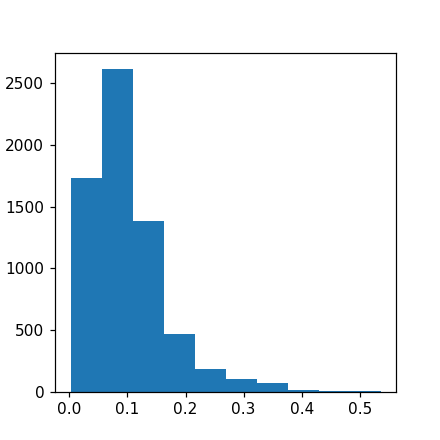

<IPython.core.display.Javascript object>


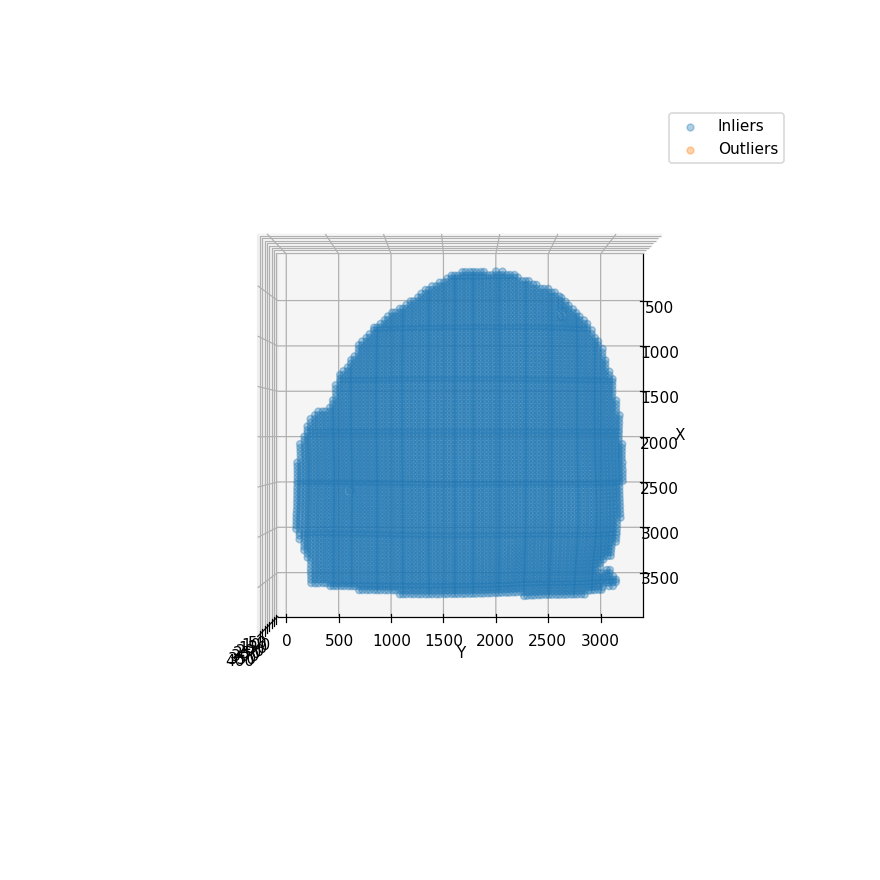

In [33]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 10 # number of nearest neighbors to use for gradient estimation
threshold = 2 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (10,10,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 2.890595408146972
Mean: 4.265004560656734
Number of inliers: 6548


<IPython.core.display.Javascript object>


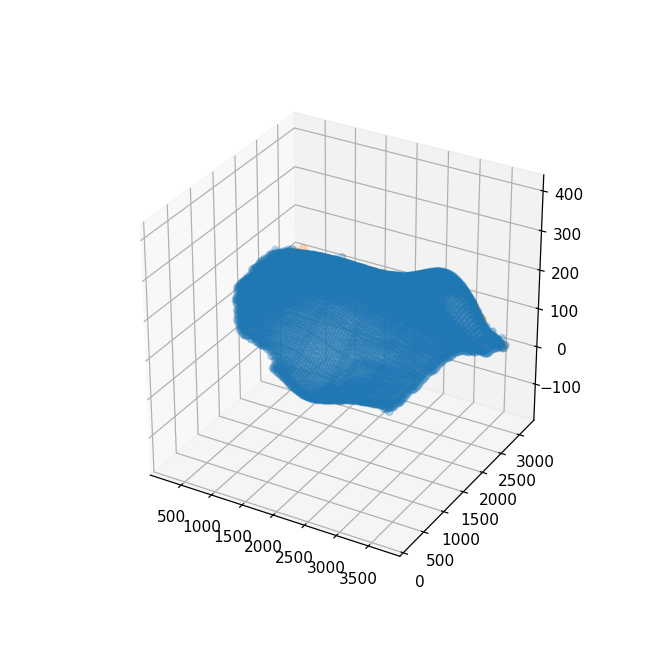

In [34]:
# Statistical outlier removal
do_outlier_removal = True
nn = 20
std_dev_threshold = 4.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    # For visualization, get the outliers that were filtered 
    a = set(tuple([tuple(tmp) for tmp in eps_new_grad]))
    aa = set(tuple([tuple(tmp) for tmp in newpts]))
    outlierss = np.asarray(tuple(a.symmetric_difference(aa)))
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.25)
    ax.scatter(outlierss[:,0],outlierss[:,1],outlierss[:,2],antialiased=True, alpha=0.25)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Top slab, bottom surface

In [39]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/bot_concave_hull.json')
json_name = 'contour_bottom' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [3900,3400]#,600]
mask_path = bdir('manual_anchor_labels/top_bot_contour.tif') # concave hull mask write path
x0 = 3000
y0 = 400
z0 = 680


##################
border_pts = read_annotations_json(contour_pts_path, json_name)
border_pts[:,0] -= x0; border_pts[:,1] -= y0; border_pts[:,2] -= z0
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/manual_anchor_labels/top_bot_contour.tif'

In [36]:
# Now mask the point cloud 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 10
mask_path = bdir('manual_anchor_labels/top_bot_contour.tif')
img_shape = [3900,3400]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

6847it [00:01, 3947.43it/s]


<IPython.core.display.Javascript object>


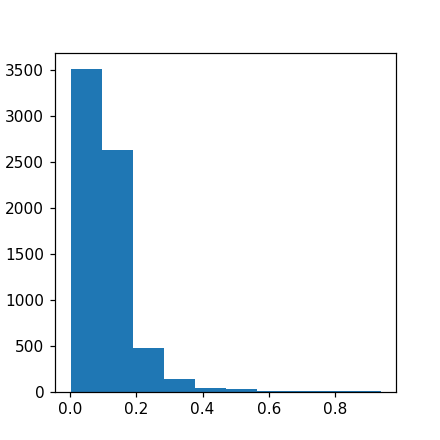

<IPython.core.display.Javascript object>


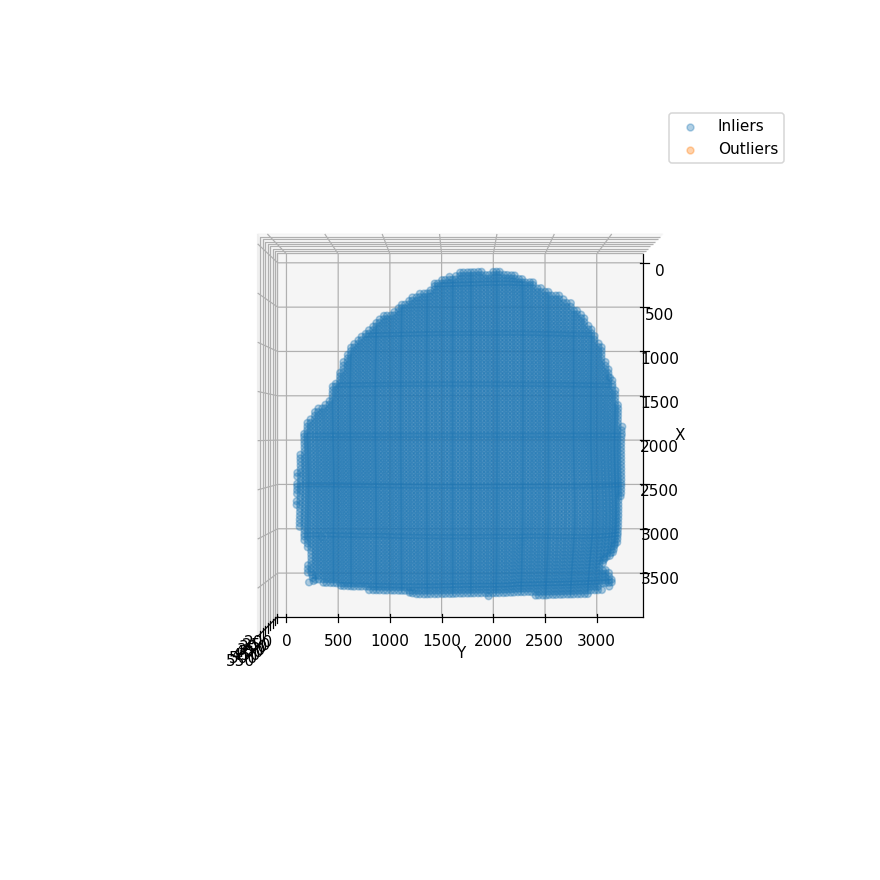

In [37]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 10 # number of nearest neighbors to use for gradient estimation
threshold = 2 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (10,10,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 3.127896852582505
Mean: 3.7048488389075507
Number of inliers: 6805


<IPython.core.display.Javascript object>


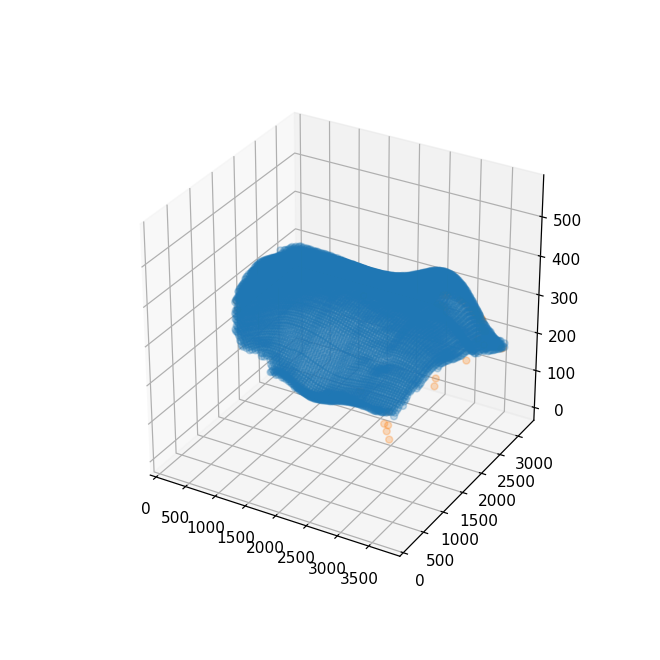

In [38]:
# Statistical outlier removal
do_outlier_removal = True
nn = 10
std_dev_threshold = 4.6
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    # For visualization, get the outliers that were filtered 
    a = set(tuple([tuple(tmp) for tmp in eps_new_grad]))
    aa = set(tuple([tuple(tmp) for tmp in newpts]))
    outlierss = np.asarray(tuple(a.symmetric_difference(aa)))
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.25)
    ax.scatter(outlierss[:,0],outlierss[:,1],outlierss[:,2],antialiased=True, alpha=0.25)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Bottom slab, top surface

## Contour outlier removal

Use the manually selected contour (in non-downsampled resolution) to filter out points outside of it

In [40]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/top_concave_hull_bottomslab_real.json')
json_name = 'top_surf_pts' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [3900,3250]#,600]
mask_path = bdir('manual_anchor_labels/bot_top_contour.tif') # concave hull mask write path
x0 = 9150
y0 = 600
z0 = 700


##################
border_pts = read_annotations_json(contour_pts_path, json_name)
border_pts[:,0] -= x0; border_pts[:,1] -= y0; border_pts[:,2] -= z0
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/manual_anchor_labels/bot_top_contour.tif'

In [41]:
# Now mask the point cloud 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 10
mask_path = bdir('manual_anchor_labels/bot_top_contour.tif')
img_shape = [3900,3250]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

7078it [00:01, 3709.06it/s]


<IPython.core.display.Javascript object>


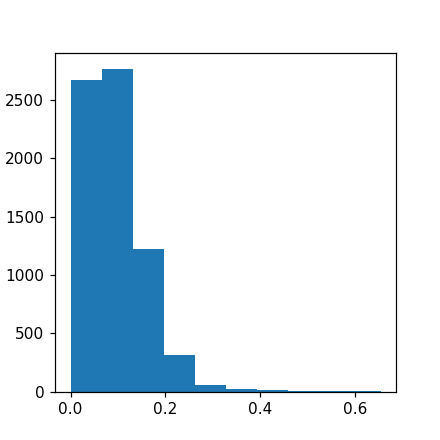

<IPython.core.display.Javascript object>


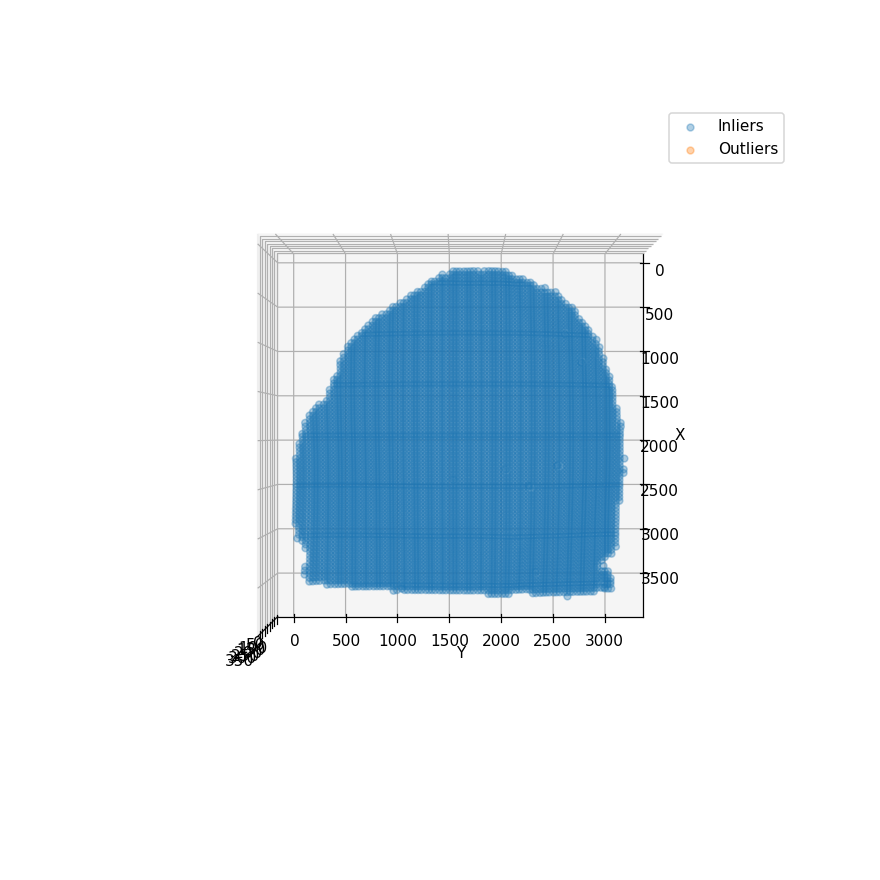

In [42]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 10 # number of nearest neighbors to use for gradient estimation
threshold = 2 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (10,10,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 3.4043416444573102
Mean: 3.277917490816615
Number of inliers: 7032


<IPython.core.display.Javascript object>


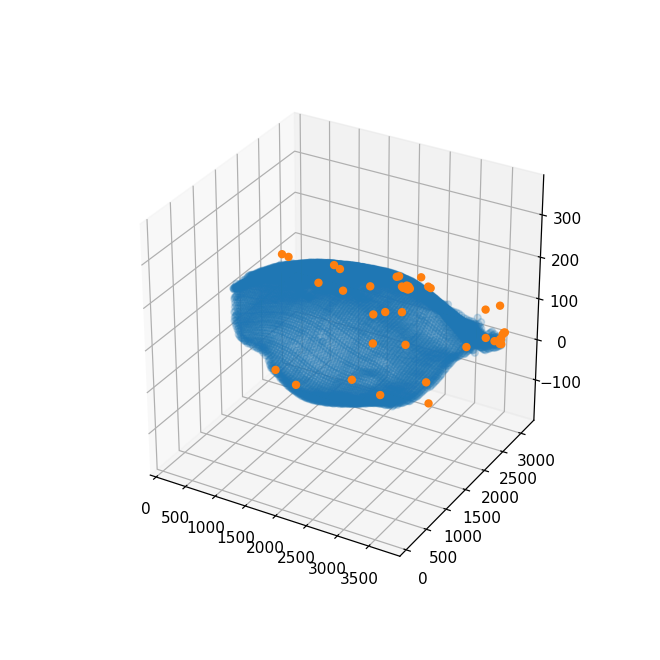

In [43]:
# Statistical outlier removal
do_outlier_removal = True
nn = 10
std_dev_threshold = 3.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    # For visualization, get the outliers that were filtered 
    a = set(tuple([tuple(tmp) for tmp in eps_new_grad]))
    aa = set(tuple([tuple(tmp) for tmp in newpts]))
    outlierss = np.asarray(tuple(a.symmetric_difference(aa)))
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.2)
    ax.scatter(outlierss[:,0],outlierss[:,1],outlierss[:,2],antialiased=True, alpha=1.0)
    ax.set_zlim3d(newpts[:,2].min()-200,newpts[:,2].max()+200)
    
    if save_path is not None:
        np.save(save_path, newpts)

### Bottom slab, bottom surface

In [44]:
# Filter out the points using the actual contour points 
contour_pts_path = bdir('manual_anchor_labels/bot_concave_hull_bottomslab_real.json')
json_name = 'bottom_surf_pts' # if contour_pts_path is json, then we need a channel name for the annotations
img_shape = [3900,3250]#,600]
mask_path = bdir('manual_anchor_labels/bot_bot_contour.tif') # concave hull mask write path
x0 = 9150
y0 = 600
z0 = 700


##################
border_pts = read_annotations_json(contour_pts_path, json_name)
border_pts[:,0] -= x0; border_pts[:,1] -= y0; border_pts[:,2] -= z0
img = Image.new('L', img_shape[:2], 0)
ImageDraw.Draw(img).polygon([tuple(border_pt.astype('int')) for border_pt in border_pts[:,:2]], outline=1, fill=1)
mask = np.array(img).T

io.writeData(mask_path,mask)

'/mnt/share3/webster/MORF8_3and4/MORF8_3and4/manual_anchor_labels/bot_bot_contour.tif'

In [45]:
# Now mask the point cloud 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts.npy')
eps_save_path = eps_path[:-4]+'_contourfiltered.npy'
upsample_factor = 10
mask_path = bdir('manual_anchor_labels/bot_bot_contour.tif')
img_shape = [3900,3250]

##################
eps_filtered = mask_point_cloud(eps_path, mask_path, img_shape, eps_save_path=eps_save_path, resample_factor=upsample_factor)

7276it [00:01, 4078.75it/s]


<IPython.core.display.Javascript object>


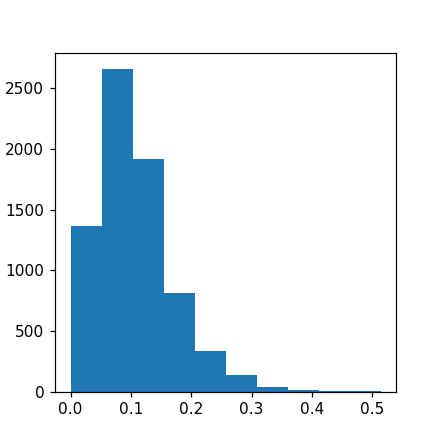

<IPython.core.display.Javascript object>


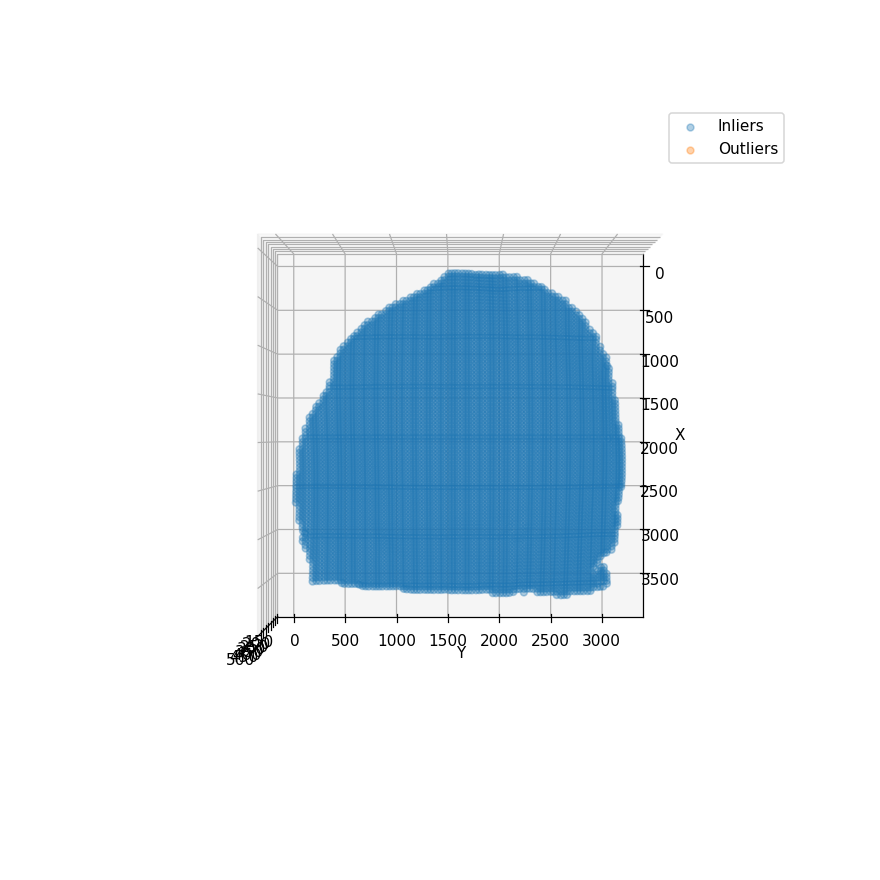

In [46]:
# Gradient outlier removal 
do_grad_removal = True 
eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered.npy')
eps_save_path = None
num_nns = 10 # number of nearest neighbors to use for gradient estimation
threshold = 2 # threshold for gradient magnitude at which to divide positives and negatives
plot= True # whether or not to plot the histogram
downsample_factor = (10,10,1)

#############################
eps_new = np.load(eps_path)
eps_new[:,0] *= downsample_factor[0]; eps_new[:,1] *= downsample_factor[1]; eps_new[:,2] *= downsample_factor[2]
if do_grad_removal:
    eps_new_grad = gradient_remove_outliers(eps_new, num_nns, threshold=threshold, plot=plot)
else:
    eps_new_grad = eps_new
if eps_save_path is not None:
    np.save(eps_save_path, eps_new_grad)

Std. dev: 2.466255016705837
Mean: 3.555071467839472
Number of inliers: 7205


<IPython.core.display.Javascript object>


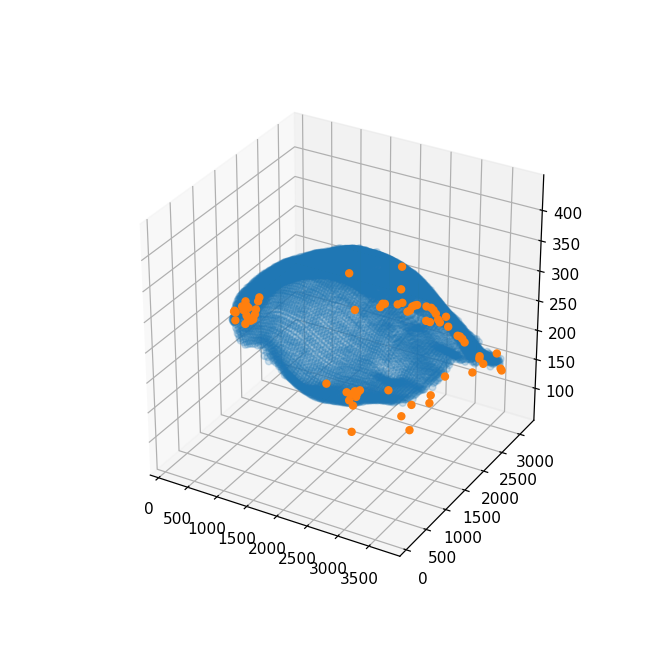

In [47]:
# Statistical outlier removal
do_outlier_removal = True
nn = 10
std_dev_threshold = 3.0
nn_mode = 'lateral'
dist_mode = 'z'
save_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')

if do_outlier_removal:
    newpts = remove_statistical_outliers(eps_new_grad, nn, std_dev_threshold, nn_mode=nn_mode, dist_mode=dist_mode)

    #Visualize  
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    
    # For visualization, get the outliers that were filtered 
    a = set(tuple([tuple(tmp) for tmp in eps_new_grad]))
    aa = set(tuple([tuple(tmp) for tmp in newpts]))
    outlierss = np.asarray(tuple(a.symmetric_difference(aa)))
    ax.scatter(newpts[:,0],newpts[:,1],newpts[:,2],antialiased=True, alpha=0.2)
    ax.scatter(outlierss[:,0],outlierss[:,1],outlierss[:,2],antialiased=True, alpha=1.0)
    ax.set_zlim3d(newpts[:,2].min()-100,newpts[:,2].max()+100)
    
    if save_path is not None:
        np.save(save_path, newpts)

## Use filtered surfaces to create masks for surface endpoints

[return to top](#top)

<a id='create_mask'></a>

#### Top

In [1]:
# Top slab
# Top surface 

# Filter based on manual contour detection

contour_pts_path = bdir('manual_anchor_labels/top_top_contour.tif')
json_name = None #'contour_top' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix+'_downsampled_surface_top.zarr')]
surf_zarr_save_paths = [bdir(name_prefix+'_downsampled_surface_top_contourfiltered.zarr')]
downsample_factor = 10
polygon_save_path = None #bdir(name_prefix+'_top_polygon.tif')


####################
surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

NameError: name 'bdir' is not defined

In [5]:
# Top slab
# Bottom surface 

# Filter based on manual contour detection

contour_pts_path = bdir('manual_anchor_labels/top_bot_contour.tif')
json_name = None#'contour_bottom' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix+'_downsampled_surface_bottom.zarr')]
surf_zarr_save_paths = [bdir(name_prefix+'_downsampled_surface_bottom_contourfiltered.zarr')]
downsample_factor = 10
polygon_save_path = None #bdir(name_prefix+'_bottom_polygon.tif')


####################
surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

### Bottom

In [6]:
# Bottom slab
# Top surface 

# Filter based on manual contour detection

contour_pts_path = bdir('manual_anchor_labels/bot_top_contour.tif')
json_name = None#'top_surf_pts' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix2+'_downsampled_surface_top.zarr')]
surf_zarr_save_paths = [bdir(name_prefix2+'_downsampled_surface_top_contourfiltered.zarr')]
downsample_factor = 10
polygon_save_path = None #bdir(name_prefix2+'_top_polygon.tif')


####################
surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

In [8]:
# Bottom slab
# Bottom surface 

# Filter based on manual contour detection

contour_pts_path = bdir('manual_anchor_labels/bot_bot_contour.tif')
json_name = None#'bottom_surf_pts' # if contour_pts_path is json, then we need a channel name for the annotations
surf_zarr_paths = [bdir(name_prefix2+'_downsampled_surface_bottom.zarr')]
surf_zarr_save_paths = [bdir(name_prefix2+'_downsampled_surface_bottom_contourfiltered.zarr')]
downsample_factor = 10
polygon_save_path = None #bdir(name_prefix2+'_bottom_polygon.tif')


####################
surfs = polygon_mask_surface(contour_pts_path, surf_zarr_paths, json_name=json_name, downsample_factor=downsample_factor,
                         surf_zarr_save_paths=surf_zarr_save_paths, polygon_save_path=polygon_save_path)

### ToDO: maybe write a function that can take the cleanedup thin surface (but these are point clouds) and make the actual surface instead of this approximation above

## UV map surfaces

[Return to top](#top)

<a id='uvmap'></a>

### First create concave mesh to enable correct flattening

## Top

<IPython.core.display.Javascript object>


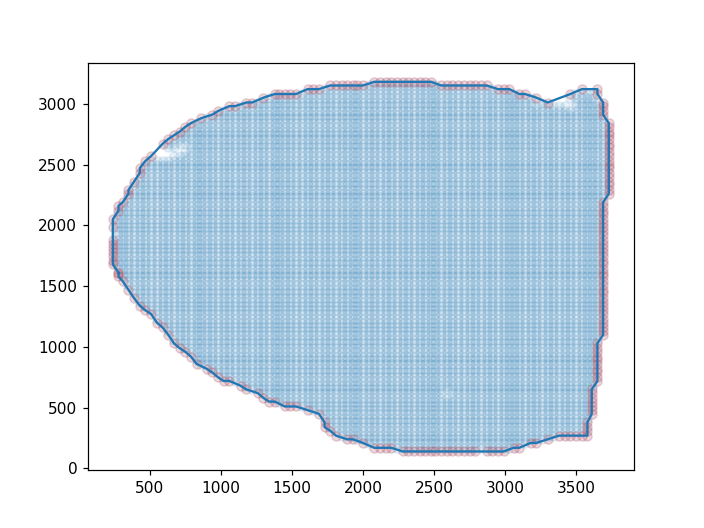

12868it [00:00, 15665.62it/s]


<IPython.core.display.Javascript object>


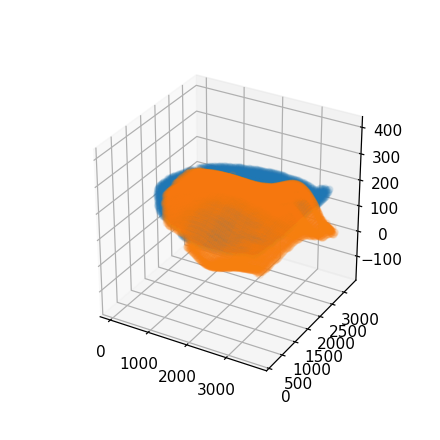

<IPython.core.display.Javascript object>


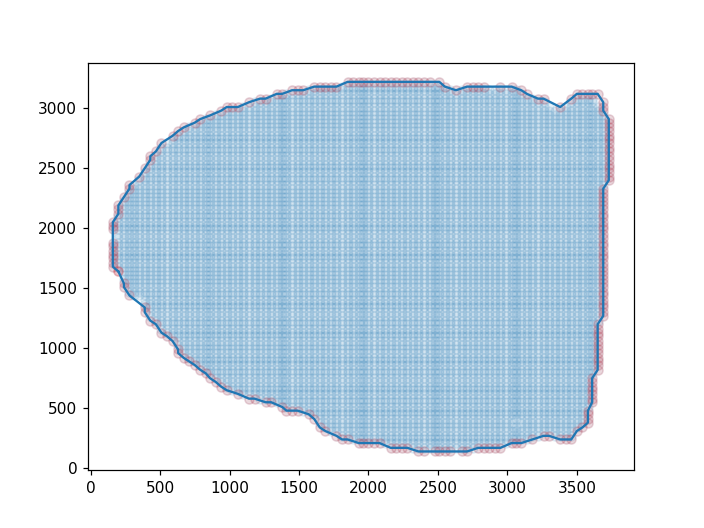

13382it [00:00, 15117.30it/s]


<IPython.core.display.Javascript object>


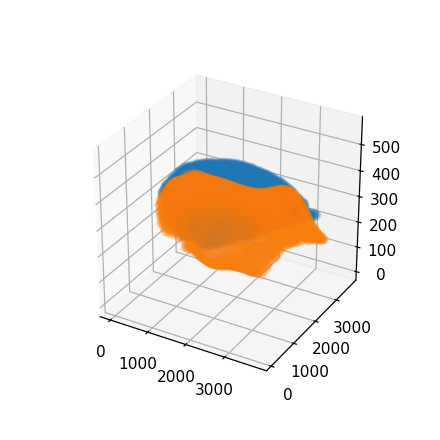

In [48]:
# Top surface 
surf_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface
surf_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')
zcoord2 = None 

plot = True
alpha = 0.01 # Parameter for producing a concave mesh. Higher alpha --> more concave

####################################
surf_eps_uv_path = surf_eps_path[:-4]+'_uv.npy'
surf_eps_uv_path2 = surf_eps_path2[:-4]+'_uv.npy'

eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot, alpha=alpha)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot, alpha=alpha)

## Bottom

<IPython.core.display.Javascript object>


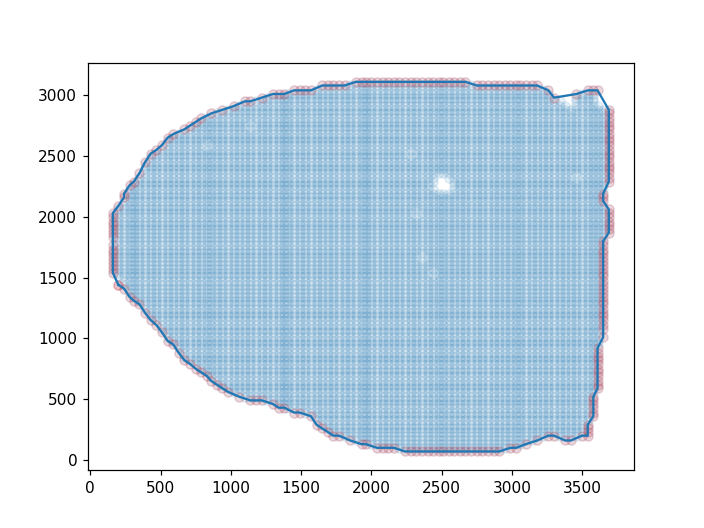

13830it [00:00, 15247.58it/s]


<IPython.core.display.Javascript object>


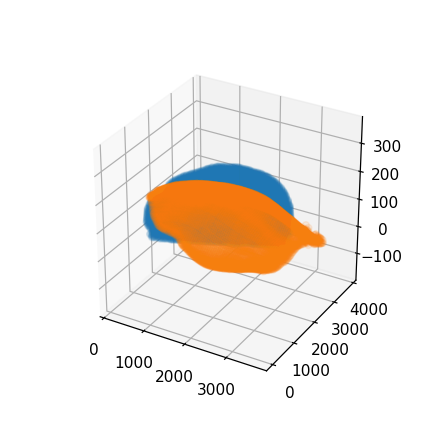

<IPython.core.display.Javascript object>


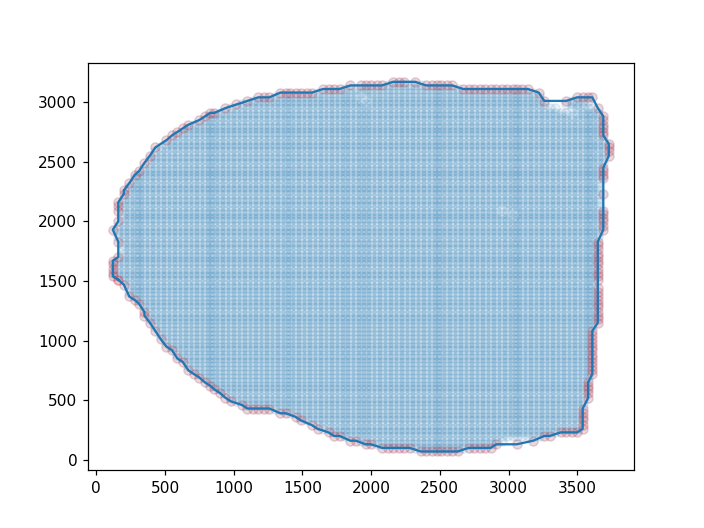

14190it [00:01, 13798.60it/s]


<IPython.core.display.Javascript object>


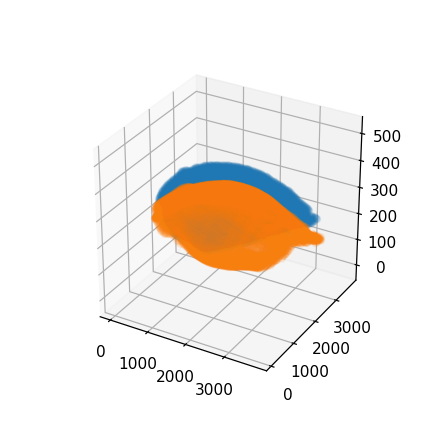

In [49]:
# Top surface 
surf_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')
zcoord = None # the z coordinate at which we want the UV map to reside. If none, then will self calculate

# Bottom surface
surf_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')
zcoord2 = None 

plot = True
alpha = 0.01 # Parameter for producing a concave mesh. Higher alpha --> more concave

####################################
surf_eps_uv_path = surf_eps_path[:-4]+'_uv.npy'
surf_eps_uv_path2 = surf_eps_path2[:-4]+'_uv.npy'

eps_uv = flatten(surf_eps_path, surf_eps_uv_path, zcoord=zcoord, plot=plot, alpha=alpha)
eps_uv2 = flatten(surf_eps_path2, surf_eps_uv_path2, zcoord=zcoord2, plot=plot, alpha=alpha)

## Align the UV maps rigidly to image  

[Return to top](#top)

<a id='uvuvalign'></a>

### Top slab

In [50]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')
top_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv.npy')
bot_eps_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')
bot_eps_uv_path = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')


Mean thickness: 166.67730604764813
Mean thickness: 166.40799412196912
New mean thickness: 166.67730604764813


<IPython.core.display.Javascript object>


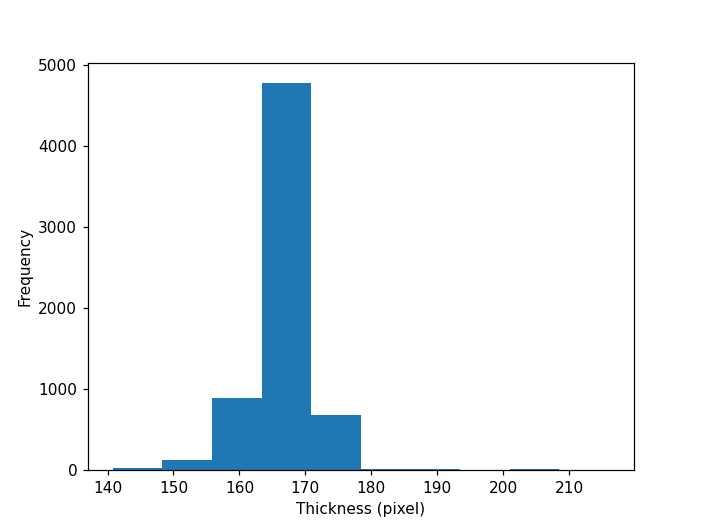

<IPython.core.display.Javascript object>


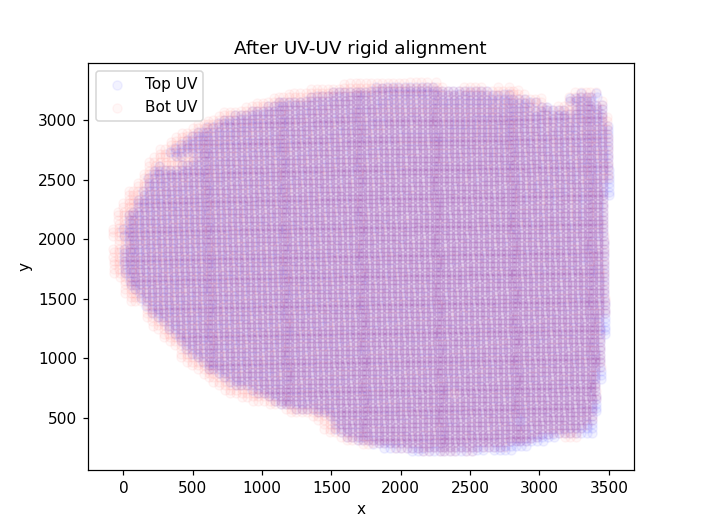

<IPython.core.display.Javascript object>


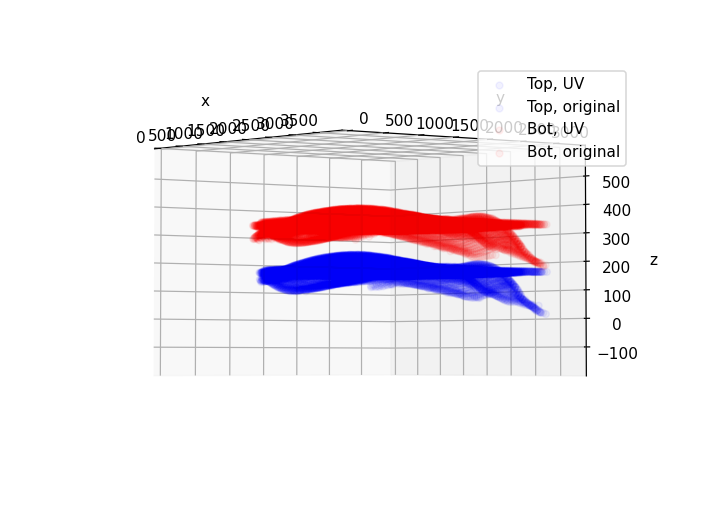

Number of top surface points:6548
Number of bottom surface points:6805


In [51]:
# Params 
thickness_filter = False
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

### Bottom slab

In [52]:
# old flattened and non-flattened paths
top_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier.npy')
top_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv.npy')
bot_eps_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier.npy')
bot_eps_uv_path = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv.npy')

# new flattened and non-flattened paths, after filtering, UV-UV aligning, and surface-UV aligning 
top_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_new.npy')
top_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv_new.npy')
bot_eps_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_new.npy')
bot_eps_uv_path2 = bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')


Mean thickness: 159.37248293515358
Mean thickness: 159.09826509368494
New mean thickness: 159.37248293515358


<IPython.core.display.Javascript object>


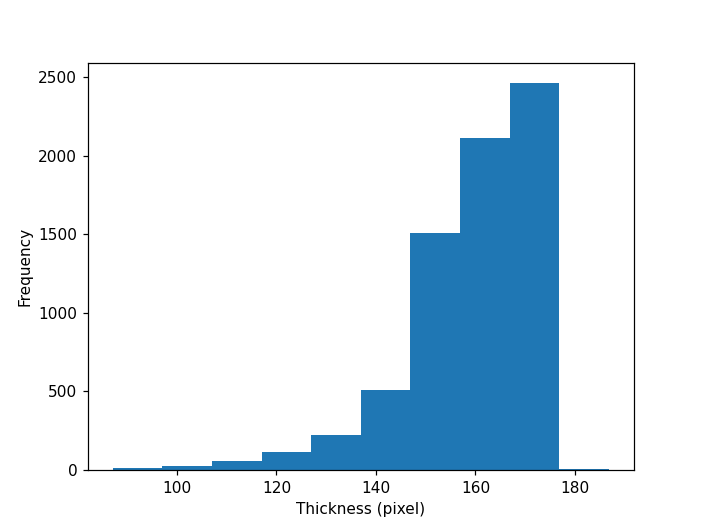

<IPython.core.display.Javascript object>


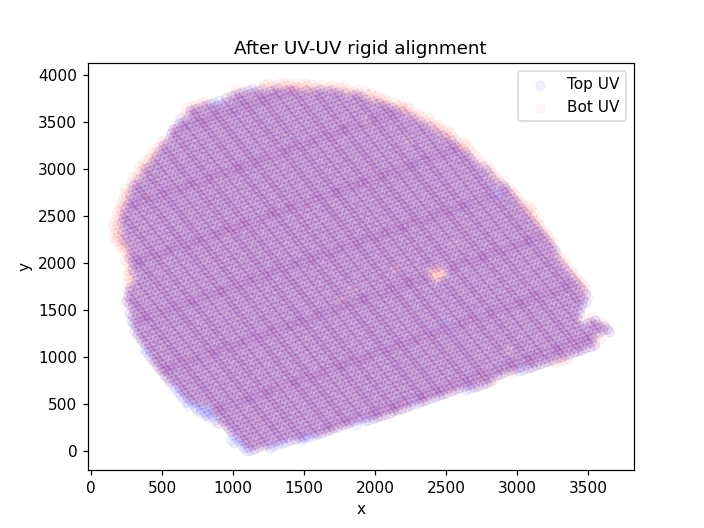

<IPython.core.display.Javascript object>


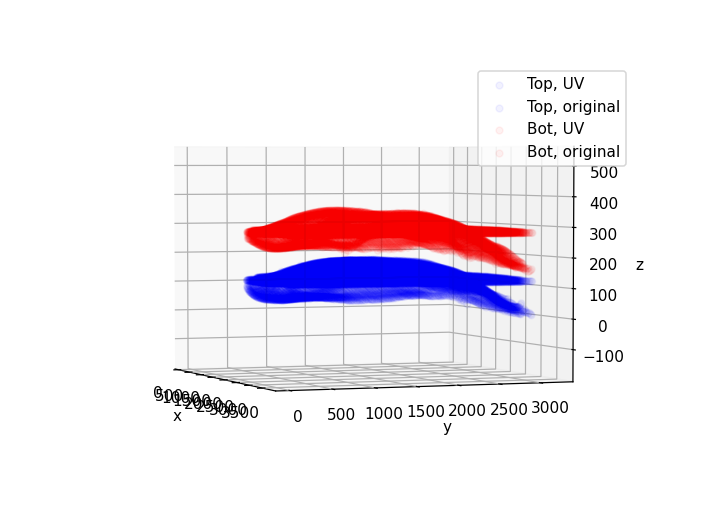

Number of top surface points:7032
Number of bottom surface points:7205


In [53]:
# Params 
thickness_filter = False
nns = 10
n_std = 2 # num std. devs away from mean thickness to remove
plot = True 


#############
bot_eps = np.load(bot_eps_path)
bot_eps_uv = np.load(bot_eps_uv_path)
top_eps = np.load(top_eps_path)
top_eps_uv = np.load(top_eps_uv_path)

top_eps_flat, top_eps_uv, bot_eps_flat, bot_eps_uv = align_uv_maps(top_eps, top_eps_uv, bot_eps, bot_eps_uv,
                                                                   thickness_filter=thickness_filter, nns=nns, n_std=n_std, plot=plot)

np.save(bot_eps_path2, bot_eps_flat)
np.save(bot_eps_uv_path2, bot_eps_uv)
np.save(top_eps_path2, top_eps_flat)
np.save(top_eps_uv_path2, top_eps_uv)

print("Number of top surface points:%d"%top_eps_flat.shape[0])
print("Number of bottom surface points:%d"%bot_eps_flat.shape[0])

## Flatten TPS warp

[Return to top](#top)

<a id='flattenwarp'></a>

### Top

In [64]:
moving_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_new.npy'),
                    bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_new.npy')]
fixed_pts_paths = [bdir(name_prefix+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv_new.npy'),
                    bdir(name_prefix+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]


fixed_zarr_path = bdir(name_prefix+'.zarr')
moving_zarr_path = bdir(name_prefix+'.zarr')
warped_zarr_path = bdir(name_prefix+'_flattened.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8
save_grid_values_path = None #bdir('warping_grids/'+name_prefix+'_grid_flatten.npy')
use_grid_values_path = bdir('warping_grids/'+name_prefix+'_grid_flatten.npy')#None

# Parameters that do not need to be changed 
R_path = None
b_path = None
static_pts_paths = None



######################################
TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Loading grid values...
Warping image...


100%|██████████| 680/680 [01:29<00:00,  7.60it/s]


Time elapsed: 2.607248 minutes
Loading z 0 - 200


100%|██████████| 200/200 [01:40<00:00,  1.89it/s]


Loading z 200 - 400


100%|██████████| 200/200 [01:42<00:00,  2.04it/s]


### Bottom

In [65]:
moving_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_new.npy'),
                    bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_new.npy')]
fixed_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_top_endpts_contourfiltered_outlier_uv_new.npy'),
                    bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]


fixed_zarr_path = bdir(name_prefix2+'.zarr')
moving_zarr_path = bdir(name_prefix2+'.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8
save_grid_values_path = None
use_grid_values_path = bdir('warping_grids/'+name_prefix2+'_grid_flatten.npy')#None

# Parameters that do not need to be changed 
R_path = None
b_path = None
static_pts_paths = None



######################################
TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Loading grid values...
Warping image...


100%|██████████| 680/680 [01:21<00:00,  8.35it/s]


Time elapsed: 2.644224 minutes
Loading z 0 - 200


100%|██████████| 200/200 [01:34<00:00,  1.94it/s]


Loading z 200 - 360


100%|██████████| 160/160 [01:15<00:00,  1.95it/s]


## Flatten all the points (manual anchor points + detected endpoints)

Transform detected endpoints and anchor points into flattened reference frame <br>

[Return to top](#top)

<a id='pointflatten'>

In [14]:
# Top slab, bottom surface

# Warped zarr path - this only determines the shape of the image to which we're transforming the grid
warped_zarr_path = bdir(name_prefix+'_flattened.zarr')

# Manual anchor points, these need to be loaded and added to pts_transform_paths list
anchors_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts.npy') # path to save unflattened anchors from json
anchors_save_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy') # path to save the flattened transformed anchors

anchors_json_path = bdir('manual_anchor_labels/left_bottom_anchors_r0.json')
annotation_name = 'anchors_left'
resample_factor = (1,1,1) # multiply this by the anchor points to get to correct reference frame 
offset = (3000,400,680) # subtract these to get the actual reference frame 


# Detected endpoints
pts_masked_path = bdir(name_prefix+'_endpoints_bottom_masked.npy')
pts_masked_save_path = bdir(name_prefix+'_endpoints_bottom_masked_flat.npy')

# Grid path
grid_path = bdir('warping_grids/'+name_prefix+'_grid_flatten.npy')
save_json=True
inverse_transform = True 

##############################
# Load manual anchor points 
if anchors_json_path[-3:] == 'csv':
    arteries = np.asarray(pd.read_csv(anchors_json_path))
    flattened_arteries = arteries[:,:3]   
elif anchors_json_path[-4:] == 'json':
    flattened_arteries = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
flattened_arteries[:,0] -= offset[0]; flattened_arteries[:,1] -= offset[1]; flattened_arteries[:,2] -= offset[2]
flattened_arteries = flattened_arteries.astype('float')
flattened_arteries[:,0] *= resample_factor[0]; flattened_arteries[:,1] *= resample_factor[1]; flattened_arteries[:,2] *= resample_factor[2]
flattened_arteries = np.round(flattened_arteries).astype('int')
np.save(anchors_path, flattened_arteries)


fixed_anchor_flat = grid_transform_pts(grid_path, anchors_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                       save_path=anchors_save_path, save_json=save_json)
fixed_detected_flat = grid_transform_pts(grid_path, pts_masked_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                         save_path=pts_masked_save_path, save_json=save_json)

In [15]:
# Bottom slab 

# Warped zarr path - this only determines the shape of the image to which we're transforming the grid
warped_zarr_path = bdir(name_prefix2+'_flattened.zarr')

# Manual anchor points, these need to be loaded and added to pts_transform_paths list
anchors_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts.npy')
anchors_save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy') # path to save the flattened transformed anchors

anchors_json_path = bdir('manual_anchor_labels/right_top_anchors_r0.json')
annotation_name = 'anchors'
resample_factor = (1,1,1) # multiply this by the anchor points to get to correct reference frame 
offset = (9150,600,700) # subtract these to get the actual reference frame

# Detected endpoints
pts_masked_path = bdir(name_prefix2+'_endpoints_top_masked.npy')
pts_masked_save_path = bdir(name_prefix2+'_endpoints_top_masked_flat.npy')

# Grid path
grid_path = bdir('warping_grids/'+name_prefix2+'_grid_flatten.npy')
save_json=True
inverse_transform = True 

##############################

# Load manual anchor points 
if anchors_json_path[-3:] == 'csv':
    arteries = np.asarray(pd.read_csv(anchors_json_path))
    flattened_arteries = arteries[:,:3]   
elif anchors_json_path[-4:] == 'json':
    flattened_arteries = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
flattened_arteries[:,0] -= offset[0]; flattened_arteries[:,1] -= offset[1]; flattened_arteries[:,2] -= offset[2]
flattened_arteries = flattened_arteries.astype('float')
flattened_arteries[:,0] *= resample_factor[0]; flattened_arteries[:,1] *= resample_factor[1]; flattened_arteries[:,2] *= resample_factor[2]
flattened_arteries = np.round(flattened_arteries).astype('int')
np.save(anchors_path, flattened_arteries)

fixed_anchor_flat = grid_transform_pts(grid_path, anchors_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                       save_path=anchors_save_path, save_json=save_json)
fixed_detected_flat = grid_transform_pts(grid_path, pts_masked_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                         save_path=pts_masked_save_path, save_json=save_json)

## Rigid alignment (using manual anchor points)

[Return to top](#top)

<a id='rigidanchor'></a>

205.51715929371363


<IPython.core.display.Javascript object>


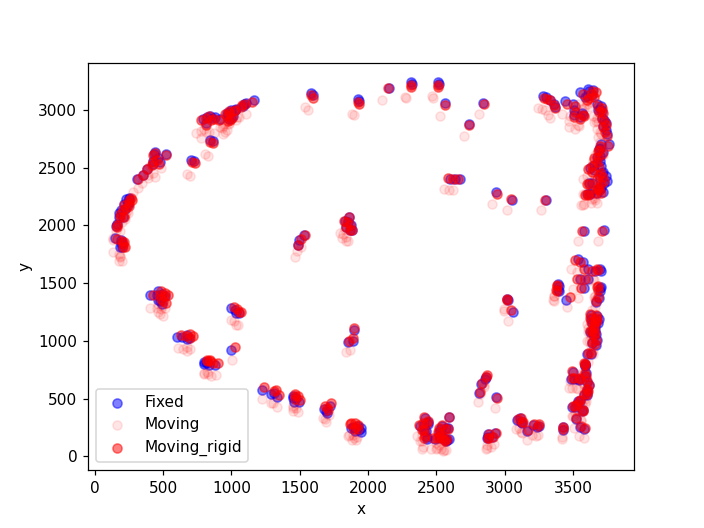

In [95]:
flattened_arteries_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy') # top slab, bottom side
flattened_arteries_path2 = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy') # bottom slab, top side 
plot2d = True # if False, plot points in 3d
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection


###############################################
flattened_arteries = np.load(flattened_arteries_path)
flattened_arteries_2 = np.load(flattened_arteries_path2)

# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

## TPS warp based on manual anchor points 

[Return to top](#top)

<a id='anchorwarp'></a>

In [96]:
moving_pts_paths = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy')]
fixed_pts_paths =  [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy')]

fixed_zarr_path = bdir(name_prefix2+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix+'_flattened_anchorwarp_r0.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers = 8 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_anchor_tps_r0.npy')
use_grid_values_path = None

# anchor parameters (using the surface on the other side and manually identified anchors on the cut surface)
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]

##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=100, chunks=chunks,zadd=0,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 177.050129 seconds
Nonrigid ave. distance [pixels]: 0.00032704547753231397
Warping grid...
Warping grid took 153.230116 seconds
Saved grid_values at /mnt/share3/webster/MORF8_3and4/MORF8_3and4/warping_grids/grid_anchor_tps_r0.npy
Warping image...


100%|██████████| 1020/1020 [01:28<00:00, 11.57it/s]


Time elapsed: 8.399302 minutes
Loading z 0 - 200


100%|██████████| 200/200 [01:45<00:00,  2.01it/s]


Loading z 200 - 400


100%|██████████| 200/200 [01:46<00:00,  2.01it/s]


Loading z 400 - 565


100%|██████████| 165/165 [01:28<00:00,  2.05it/s]


### Warp all of the moving endpoints to the new frame so we can visualize and do next rounds

flat reference frame --> anchor_r0 reference frame (moving)

In [16]:
# Warped zarr path - this only determines the shape of the image to which we're transforming the grid
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r0.zarr')

# Manual anchor points, these need to be loaded and added to pts_transform_paths list
anchors_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy')
anchors_save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r0.npy') # path to save the flattened transformed anchors

# Detected endpoints
pts_masked_path = bdir(name_prefix2+'_endpoints_top_masked_flat.npy')
pts_masked_save_path = bdir(name_prefix2+'_endpoints_top_masked_flat_anchorwarp_r0.npy')

# Grid path
grid_path = bdir('warping_grids/grid_anchor_tps_r0.npy')
save_json=False
inverse_transform = True 

##############################
anchor_flat = grid_transform_pts(grid_path, anchors_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                       save_path=anchors_save_path, save_json=save_json)
detected_flat = grid_transform_pts(grid_path, pts_masked_path, warped_zarr_path,inverse_transform=inverse_transform, 
                                         save_path=pts_masked_save_path, save_json=save_json)

### Visualize anchor points to json

In [98]:
# Convert anchor points to json for visualization 
anchor_pts_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy') # this will be the flattened fixed anchor points

#############
anchor_pts = np.load(anchor_pts_path)
numpy_to_json(anchor_pts, anchor_pts_path[:-4]+'.json')

In [99]:
# Convert anchor points to json for visualization 
anchor_pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r0.npy') # this will be the flattened fixed anchor points

#############
anchor_pts = np.load(anchor_pts_path)
numpy_to_json(anchor_pts, anchor_pts_path[:-4]+'.json')

## Feature matching 

[Return to top](#top)

<a id='featmatch'></a>

In [17]:
# I/O 
moving_coords_path = bdir(name_prefix2+'_endpoints_top_masked_flat_anchorwarp_r0.npy')
fixed_coords_path = bdir(name_prefix+'_endpoints_bottom_masked_flat.npy')

moving_coords_matched_path = bdir(name_prefix2+'_endpoints_top_matched.npy')
fixed_coords_matched_path = bdir(name_prefix+'_endpoints_bottom_matched.npy')


# Fixed image zarr
z = zarr.open(bdir(name_prefix+'_flattened.zarr'),mode='r')
fixed_img_size = z.shape

# Feature descriptor parameters 
num_nn = 7
search_radius = 100 
ratio_thresh = 0.9
num_nn_used = 4
return_nn = False
use3d = True 




#######################
moving_coords = np.load(moving_coords_path)
fixed_coords = np.load(fixed_coords_path)

fixed_feats = compute_spatial_descriptor(fixed_coords, num_nn=num_nn)
moving_feats = compute_spatial_descriptor(moving_coords, num_nn=num_nn)

fixed_coords_matched, fixed_feats_matched, moving_coords_matched, moving_feats_matched, a, b = \
                compute_feature_matches(fixed_coords, fixed_feats, moving_coords, moving_feats,
                                       use3d, search_radius, ratio_thresh, num_nn_used, return_nn=return_nn)

np.save(moving_coords_matched_path, moving_coords_matched)
np.save(fixed_coords_matched_path, fixed_coords_matched)

100%|██████████| 4719/4719 [04:00<00:00, 19.59it/s]


In [21]:
print(moving_coords_matched.shape,fixed_coords_matched.shape)

(1686, 3) (1686, 3)


### RANSAC

In [77]:
moving_coords_ransac_path = bdir(name_prefix2+'_endpoints_top_matched_ransac.npy')
fixed_coords_ransac_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac.npy')

# RANSAC
error_threshold = 10 # ideal is 35 
use_3d = True 
use_local_ransac = True

opts = {'apply_affine_transform' : False, 
        'min_samples' : 1, # this parameter doesn't actually matter
       'num_x_tiles' : 8,
       'num_y_tiles' : 7, # make these around 500x500 sections 
       'size_image' : fixed_img_size[:2],
       'min_matches' : 25}




#################### Filter outliers with RANSAC
fixed_coords_r, moving_coords_r, fixed_feats_r, moving_feats_r = apply_ransac(fixed_coords_matched, moving_coords_matched, 
                                                                              fixed_feats_matched, moving_feats_matched, 
                                                                    error_threshold, use_3d, use_local_ransac, **opts)

np.save(fixed_coords_ransac_path, fixed_coords_r)
np.save(moving_coords_ransac_path, moving_coords_r)

Not enough matches in in tile (0,0), skipping...
Not enough matches in in tile (0,1), skipping...
Not enough matches in in tile (0,2), skipping...
Not enough matches in in tile (0,3), skipping...
Not enough matches in in tile (0,4), skipping...
Not enough matches in in tile (0,5), skipping...
Not enough matches in in tile (0,6), skipping...
Not enough matches in in tile (1,0), skipping...
Not enough matches in in tile (1,1), skipping...
Number of matches found: 27
Finished filtering tile (1,2)
Number of matches found: 41
Finished filtering tile (1,3)
Number of matches found: 36
Finished filtering tile (1,4)
Not enough matches in in tile (1,5), skipping...
Not enough matches in in tile (1,6), skipping...
Not enough matches in in tile (2,0), skipping...
Not enough matches in in tile (2,1), skipping...
Number of matches found: 22
Finished filtering tile (2,2)
Number of matches found: 29
Finished filtering tile (2,3)
Number of matches found: 62
Finished filtering tile (2,4)
Not enough matc

In [78]:
print(fixed_coords_r.shape, moving_coords_r.shape)

(684, 3) (684, 3)


### Filter out points that are too far away in z?

<IPython.core.display.Javascript object>


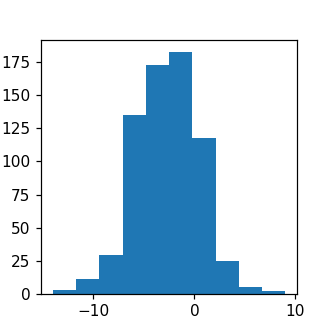

<IPython.core.display.Javascript object>


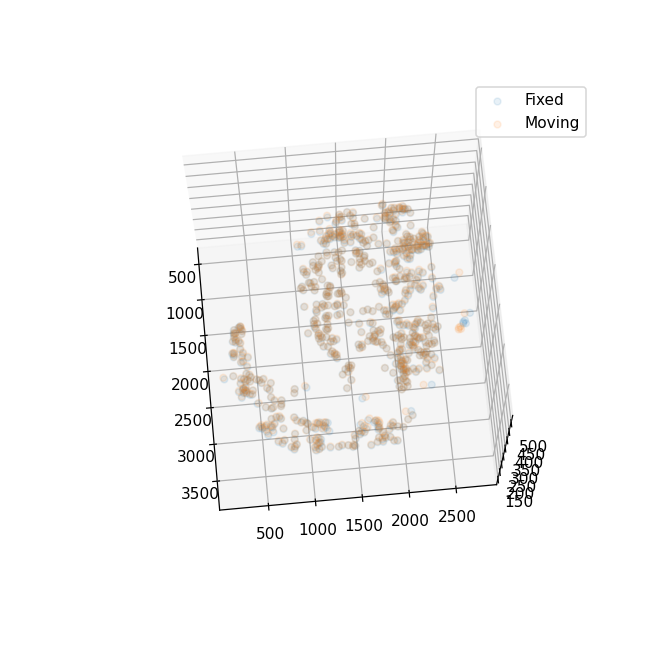

Number of feature matches: 1686
Number of RANSAC matches: 640


In [79]:
# Might need to filter out matches that are too far away in z
max_z_difference = 7


#############
plt.figure(figsize=(3,3))
plt.hist(fixed_coords_r[:,2]-moving_coords_r[:,2])
plt.show()

fixed_new = fixed_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <= max_z_difference]
moving_new = moving_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <=max_z_difference]

#Plot these coordinates
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(fixed_new[:,0],fixed_new[:,1],fixed_new[:,2],antialiased=True, alpha=0.1)
ax.scatter(moving_new[:,0],moving_new[:,1],moving_new[:,2],antialiased=True,alpha=0.1)
ax.set_zlim3d(fixed_coords_r[:,2].min()-200,fixed_coords_r[:,2].max()+200)
ax.legend(['Fixed','Moving'])


print("Number of feature matches:",fixed_coords_matched.shape[0])
print("Number of RANSAC matches:",fixed_new.shape[0])


np.save(fixed_coords_ransac_path, fixed_new)
np.save(moving_coords_ransac_path, moving_new)

## Visualize matched points in Neuroglancer

In [80]:
# Convert anchor points to json for visualization 
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac.npy')

#############
pts = np.load(pts_path)
numpy_to_json(pts, pts_path[:-4]+'.json')

In [81]:
# Convert anchor points to json for visualization 
pts_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac.npy') 

#############
pts = np.load(pts_path)
numpy_to_json(pts, pts_path[:-4]+'.json')

### Get rid of redundant or incorrect matched points

In [113]:
annotations_path = bdir('manual_anchor_labels/R-lec_2beremoved.json') # path to annotations json of points to be removed
json_name = 'R-lec_endpoints_2beremoved'

pts_moving_path = bdir(name_prefix2+'_endpoints_top_matched_ransac.npy') # moving matched points to be removed
pts_fixed_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac.npy') # fixed matched points to be removed

selected_pts = 'moving' # can be 'moving' or 'fixed'; if 'moving', then we search through pts_moving for the ones to be removed

########################
pts = read_annotations_json(annotations_path, json_name)

moving_pts = np.load(pts_moving_path)
fixed_pts = np.load(pts_fixed_path)

from sklearn.neighbors import KDTree
if selected_pts == 'moving':
    kdt = KDTree(moving_pts)
else:
    kdt = KDTree(fixed_pts)
    
_, inds = kdt.query(pts,k=1)
moving_pts_new = np.delete(moving_pts,inds[:,0],axis=0)
fixed_pts_new = np.delete(fixed_pts,inds[:,0],axis=0)

np.save(pts_moving_path[:-4]+'_filtered.npy',moving_pts_new)
np.save(pts_fixed_path[:-4]+'_filtered.npy',fixed_pts_new)

numpy_to_json(moving_pts_new,pts_moving_path[:-4]+'_filtered.json')  
numpy_to_json(fixed_pts_new,pts_fixed_path[:-4]+'_filtered.json')  

# Load in R1 manual anchor points

In [115]:
# Load in the new anchor points (combine the old anchor points with the new ones)

json_path = bdir('manual_anchor_labels/r1_labels.json')
new_anchor_pts_moving_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1.npy')
new_anchor_pts_fixed_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy')
moving_name = 'r1_anchor_R'
fixed_name = 'r1_anchor_L'

##############
moving_pts_new = read_annotations_json(json_path, moving_name, sink_path=new_anchor_pts_moving_path)
fixed_pts_new = read_annotations_json(json_path, fixed_name, sink_path=new_anchor_pts_fixed_path)


# Also save individually in JSON so that we can visualize 
numpy_to_json(fixed_pts_new, new_anchor_pts_fixed_path[:-4]+'.json')
numpy_to_json(moving_pts_new, new_anchor_pts_moving_path[:-4]+'.json')
print(moving_pts_new.shape, fixed_pts_new.shape)

(437, 3) (437, 3)


## Unwarp all of these points (to flattened ref frame)

R1 anchor: R0 anchor --> flat <br>
R0 anchor: already in flat frame <br>
detected_filtered: R0 anchor --> flat <br>

In [116]:
# R1 anchor points (in the R0 reference frame)
grid_path = bdir('warping_grids/grid_anchor_tps_r0.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r0.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy')
save_json = False 
inverse_transform = False 


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [117]:
# Detected endpoints (filtered so in r0 reference frame)
grid_path = bdir('warping_grids/grid_anchor_tps_r0.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r0.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered_flatframe.npy')
save_json = False 
inverse_transform = False 


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

## TPS Warp round 1

[Return to top](#top)

### Warp using original anchor pts and new anchor pts 
From the flattened frame

<a id='tpswarp'></a>

(1359, 3) (1359, 3)
204.18940902949853


<IPython.core.display.Javascript object>


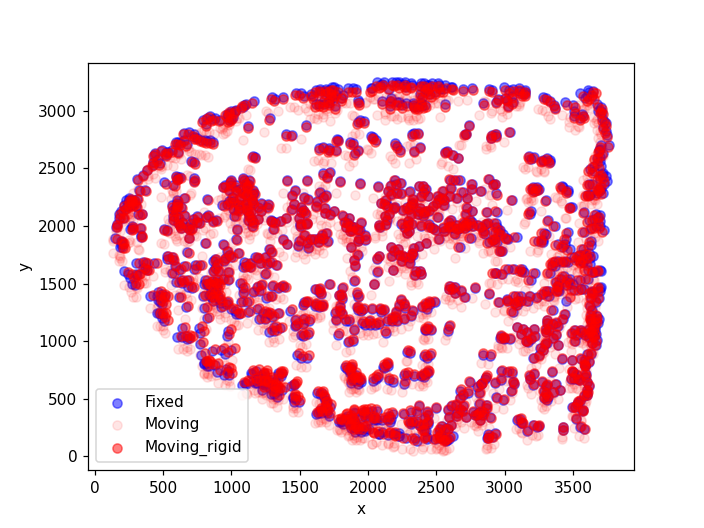

In [121]:
# First do rigid alignment again

plot2d = True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
flattened_arteries_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                           bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                           bdir(name_prefix+'_endpoints_bottom_matched_ransac_filtered.npy')] # detected eps
flattened_arteries_paths2 = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                            bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                            bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered_flatframe.npy')] #detected eps 
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')

In [122]:
# I/O 

moving_pts_paths = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                    bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered_flatframe.npy')] #detected eps 
fixed_pts_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                   bdir(name_prefix+'_endpoints_bottom_matched_ransac_filtered.npy')] # detected eps

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers=8

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_tps_r1.npy')
use_grid_values_path = None

# anchors
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]


##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)


# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 251.888512 seconds
Nonrigid ave. distance [pixels]: 0.0011874389194425027
Warping grid...
Warping grid took 170.972665 seconds
Saved grid_values at /mnt/share3/webster/MORF8_3and4/MORF8_3and4/warping_grids/grid_tps_r1.npy
Warping image...


100%|██████████| 1020/1020 [01:42<00:00,  9.91it/s]


Time elapsed: 10.152355 minutes


In [123]:
 # Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Loading z 0 - 200


100%|██████████| 200/200 [01:42<00:00,  1.97it/s]


Loading z 200 - 400


100%|██████████| 200/200 [01:44<00:00,  2.11it/s]


Loading z 400 - 564


100%|██████████| 164/164 [01:23<00:00,  1.95it/s]


# Warp all points to new reference frame (r1)
[Return to top](#top)
<a id='warp_points_r1'></a><br>
r0 anchor points (flat --> r1) <br>
ALL detected eps (flat --> r1) < top and bottom> <br>
filtered detected eps (r0) (flat --> r1) (so we can do feature matching again)  <br>
r1 anchor points (flat --> r1)  <br>


In [136]:
# R1 moving anchor points: transfrom from flattened frame to r1 frame 
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_r1frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [137]:
# R0 moving anchor points: transfrom from flattened frame to r1 frame 
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_r1frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [138]:
# Filtered ransac matched points: transfrom from flattened frame to r1 frame (moving)
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_filtered_r1frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [139]:
# All detected endpoints (moving): transfrom from flattened frame to r1 frame
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_masked_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_masked_r1frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

# Redo feature matching in R1 frame

[Return to top](#top)

<a id='feature_match_r1'></a>

In [145]:
# I/O 
moving_coords_path = bdir(name_prefix2+'_endpoints_top_masked_r1frame.npy')
fixed_coords_path = bdir(name_prefix+'_endpoints_bottom_masked_flat.npy')

moving_coords_matched_path = bdir(name_prefix2+'_endpoints_top_matched_r1frame.npy')
fixed_coords_matched_path = bdir(name_prefix+'_endpoints_bottom_matched_r1frame.npy')


# Fixed image zarr
z = zarr.open(bdir(name_prefix+'_flattened.zarr'),mode='r')
fixed_img_size = z.shape

# Feature descriptor parameters 
num_nn = 6
search_radius = 15 
ratio_thresh = 0.9
num_nn_used = 3
return_nn = False
use3d = True 




#######################
moving_coords = np.load(moving_coords_path)
fixed_coords = np.load(fixed_coords_path)

fixed_feats = compute_spatial_descriptor(fixed_coords, num_nn=num_nn)
moving_feats = compute_spatial_descriptor(moving_coords, num_nn=num_nn)

fixed_coords_matched, fixed_feats_matched, moving_coords_matched, moving_feats_matched, a, b = \
                compute_feature_matches(fixed_coords, fixed_feats, moving_coords, moving_feats,
                                       use3d, search_radius, ratio_thresh, num_nn_used, return_nn=return_nn)

# np.save(moving_coords_matched_path, moving_coords_matched)
# np.save(fixed_coords_matched_path, fixed_coords_matched)

100%|██████████| 4719/4719 [00:13<00:00, 358.00it/s]


In [146]:
print(moving_coords_matched.shape,fixed_coords_matched.shape)

(2635, 3) (2635, 3)


### RANSAC

In [147]:
moving_coords_ransac_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2.npy')
fixed_coords_ransac_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2.npy')

# RANSAC
error_threshold = 10 # ideal is 35 
use_3d = True 
use_local_ransac = True

opts = {'apply_affine_transform' : False, 
        'min_samples' : 1, # this parameter doesn't actually matter
       'num_x_tiles' : 8,
       'num_y_tiles' : 7, # make these around 500x500 sections 
       'size_image' : fixed_img_size[:2],
       'min_matches' : 25}




#################### Filter outliers with RANSAC
fixed_coords_r, moving_coords_r, fixed_feats_r, moving_feats_r = apply_ransac(fixed_coords_matched, moving_coords_matched, 
                                                                              fixed_feats_matched, moving_feats_matched, 
                                                                    error_threshold, use_3d, use_local_ransac, **opts)

np.save(fixed_coords_ransac_path, fixed_coords_r)
np.save(moving_coords_ransac_path, moving_coords_r)

Not enough matches in in tile (0,0), skipping...
Not enough matches in in tile (0,1), skipping...
Not enough matches in in tile (0,2), skipping...
Number of matches found: 19
Finished filtering tile (0,3)
Not enough matches in in tile (0,4), skipping...
Not enough matches in in tile (0,5), skipping...
Not enough matches in in tile (0,6), skipping...
Not enough matches in in tile (1,0), skipping...
Not enough matches in in tile (1,1), skipping...
Number of matches found: 40
Finished filtering tile (1,2)
Number of matches found: 68
Finished filtering tile (1,3)
Number of matches found: 53
Finished filtering tile (1,4)
Not enough matches in in tile (1,5), skipping...
Not enough matches in in tile (1,6), skipping...
Not enough matches in in tile (2,0), skipping...
Number of matches found: 24
Finished filtering tile (2,1)
Number of matches found: 62
Finished filtering tile (2,2)
Number of matches found: 53
Finished filtering tile (2,3)
Number of matches found: 88
Finished filtering tile (2,

In [148]:
print(fixed_coords_r.shape, moving_coords_r.shape)

(1385, 3) (1385, 3)


### Filter out points that are too far away in z?

<IPython.core.display.Javascript object>


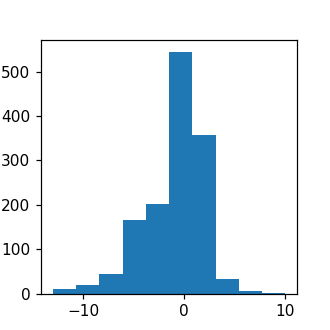

<IPython.core.display.Javascript object>


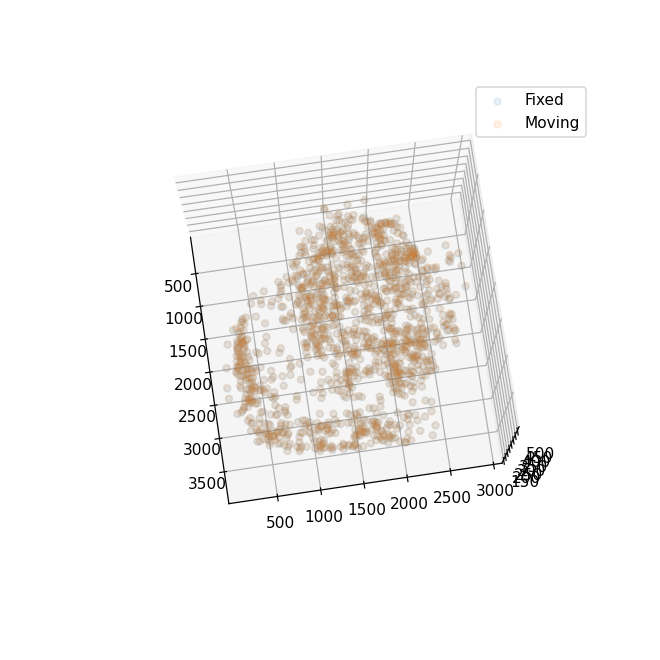

Number of feature matches: 2635
Number of RANSAC matches: 1337


In [150]:
# Might need to filter out matches that are too far away in z
max_z_difference = 7


#############
plt.figure(figsize=(3,3))
plt.hist(fixed_coords_r[:,2]-moving_coords_r[:,2])
plt.show()

fixed_new = fixed_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <= max_z_difference]
moving_new = moving_coords_r[np.abs(fixed_coords_r[:,2]-moving_coords_r[:,2]) <=max_z_difference]

#Plot these coordinates
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(fixed_new[:,0],fixed_new[:,1],fixed_new[:,2],antialiased=True, alpha=0.1)
ax.scatter(moving_new[:,0],moving_new[:,1],moving_new[:,2],antialiased=True,alpha=0.1)
ax.set_zlim3d(fixed_coords_r[:,2].min()-200,fixed_coords_r[:,2].max()+200)
ax.legend(['Fixed','Moving'])


print("Number of feature matches:",fixed_coords_matched.shape[0])
print("Number of RANSAC matches:",fixed_new.shape[0])


np.save(fixed_coords_ransac_path, fixed_new)
np.save(moving_coords_ransac_path, moving_new)

## Get rid of points that overlap with the manually identified anchor points

<IPython.core.display.Javascript object>


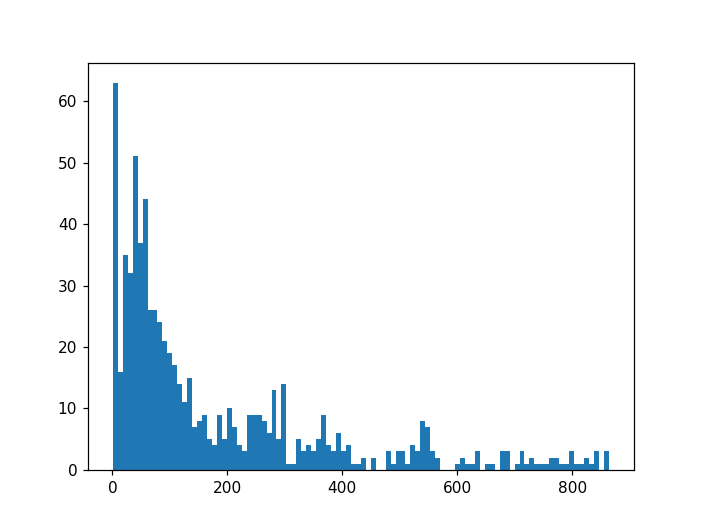

Deleted 64 points


<IPython.core.display.Javascript object>


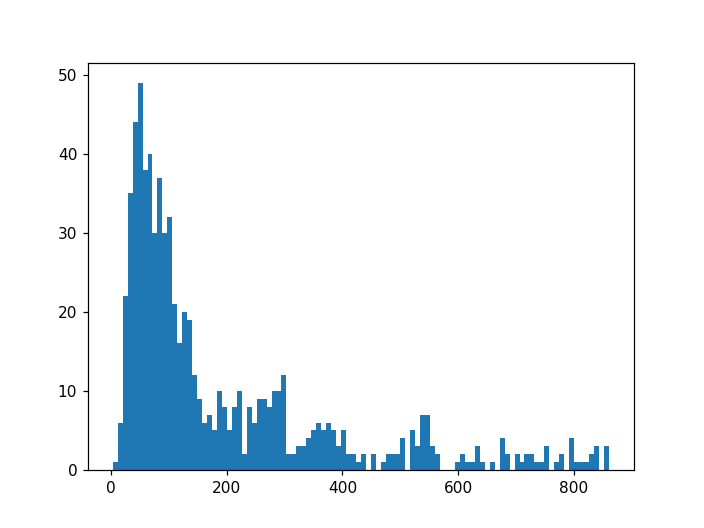

Deleted 1 points


In [185]:
# collect all the anchor points that we don't want to overlap
# make sure it's in the R1 (correct) frame of reference 
anchor_pts_r0_fixed_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy')
anchor_pts_r1_fixed_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy')

# 
detected_moving_coords_r1_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2.npy')
detected_fixed_coords_r1_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2.npy')


dist_thresh = 10 # get rid of points that are detected within this distance of a manually ID'd anchor point

#########################
anchor_pts_r0_fixed = np.load(anchor_pts_r0_fixed_path)
anchor_pts_r1_fixed = np.load(anchor_pts_r1_fixed_path)
detected_moving_coords_r1 = np.load(detected_moving_coords_r1_path)
detected_fixed_coords_r1 = np.load(detected_fixed_coords_r1_path)

from sklearn.neighbors import KDTree

kdt = KDTree(detected_moving_coords_r1)
dists, inds = kdt.query(np.concatenate((anchor_pts_r0_fixed,anchor_pts_r1_fixed),axis=0),k=1)
plt.figure()
plt.hist(dists[:,0], bins=100)
plt.show()

detected_moving_coords_r1_new = np.delete(detected_moving_coords_r1,inds[dists[:,0]<=dist_thresh],axis=0)
detected_fixed_coords_r1_new = np.delete(detected_fixed_coords_r1,inds[dists[:,0]<=dist_thresh],axis=0)
print("Deleted %d points"%(len(inds[dists[:,0]<=dist_thresh])))


## Redo it with the fixed points as well 
kdt = KDTree(detected_fixed_coords_r1_new)
dists, inds = kdt.query(np.concatenate((anchor_pts_r0_fixed,anchor_pts_r1_fixed),axis=0),k=1)
plt.figure()
plt.hist(dists[:,0], bins=100)
plt.show()

detected_moving_coords_r1_new = np.delete(detected_moving_coords_r1_new,inds[dists[:,0]<=dist_thresh],axis=0)
detected_fixed_coords_r1_new = np.delete(detected_fixed_coords_r1_new,inds[dists[:,0]<=dist_thresh],axis=0)
print("Deleted %d points"%(len(inds[dists[:,0]<=dist_thresh])))

np.save(detected_moving_coords_r1_path[:-4]+'_new.npy',detected_moving_coords_r1_new)
np.save(detected_fixed_coords_r1_path[:-4]+'_new.npy',detected_fixed_coords_r1_new)

## Visualize matched points in Neuroglancer

In [186]:
# Convert anchor points to json for visualization 
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new.npy')

#############
pts = np.load(pts_path)
numpy_to_json(pts, pts_path[:-4]+'.json')

In [187]:
# Convert anchor points to json for visualization 
pts_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new.npy') 

#############
pts = np.load(pts_path)
numpy_to_json(pts, pts_path[:-4]+'.json')

### Get rid of redundant or incorrect matched points

In [188]:
annotations_path = bdir('manual_anchor_labels/r2_labels.json') # path to annotations json of points to be removed
json_name = 'R-lec_2beremoved'

pts_moving_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new.npy') # moving matched points to be removed
pts_fixed_path = bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new.npy') # fixed matched points to be removed

selected_pts = 'moving' # can be 'moving' or 'fixed'; if 'moving', then we search through pts_moving for the ones to be removed

########################
pts = read_annotations_json(annotations_path, json_name)

moving_pts = np.load(pts_moving_path)
fixed_pts = np.load(pts_fixed_path)

from sklearn.neighbors import KDTree
if selected_pts == 'moving':
    kdt = KDTree(moving_pts)
else:
    kdt = KDTree(fixed_pts)
    
_, inds = kdt.query(pts,k=1)
moving_pts_new = np.delete(moving_pts,inds[:,0],axis=0)
fixed_pts_new = np.delete(fixed_pts,inds[:,0],axis=0)

np.save(pts_moving_path[:-4]+'_filtered.npy',moving_pts_new)
np.save(pts_fixed_path[:-4]+'_filtered.npy',fixed_pts_new)

numpy_to_json(moving_pts_new,pts_moving_path[:-4]+'_filtered.json')  
numpy_to_json(fixed_pts_new,pts_fixed_path[:-4]+'_filtered.json')  

# Load in R2 manual anchor points

In [190]:
# Load in the new anchor points (combine the old anchor points with the new ones)

json_path = bdir('manual_anchor_labels/r2_labels.json')
new_anchor_pts_moving_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2.npy')
new_anchor_pts_fixed_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r2.npy')
moving_name = 'r2_anchor_R'
fixed_name = 'r2_anchor_L'

##############
moving_pts_new = read_annotations_json(json_path, moving_name, sink_path=new_anchor_pts_moving_path)
fixed_pts_new = read_annotations_json(json_path, fixed_name, sink_path=new_anchor_pts_fixed_path)


# Also save individually in JSON so that we can visualize 
numpy_to_json(fixed_pts_new, new_anchor_pts_fixed_path[:-4]+'.json')
numpy_to_json(moving_pts_new, new_anchor_pts_moving_path[:-4]+'.json')
print(moving_pts_new.shape, fixed_pts_new.shape)

(586, 3) (586, 3)


## Unwarp all of these points (to flattened ref frame)

R2 anchor: r2 anchor --> flat <br>
detected_filtered: R2 anchor --> flat <br>

In [191]:
# R2 anchor points (in the R1 reference frame)
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy')
save_json = False 
inverse_transform = False 


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [192]:
# Detected endpoints (filtered so in r1 reference frame)
grid_path = bdir('warping_grids/grid_tps_r1.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r1.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')
save_json = False 
inverse_transform = False 


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

## TPS Warp round 2

[Return to top](#top)

### Warp using original anchor pts and new anchor pts 
From the flattened frame

<a id='tpswarp_r2'></a>

(2585, 3) (2585, 3)
204.08308679865164


<IPython.core.display.Javascript object>


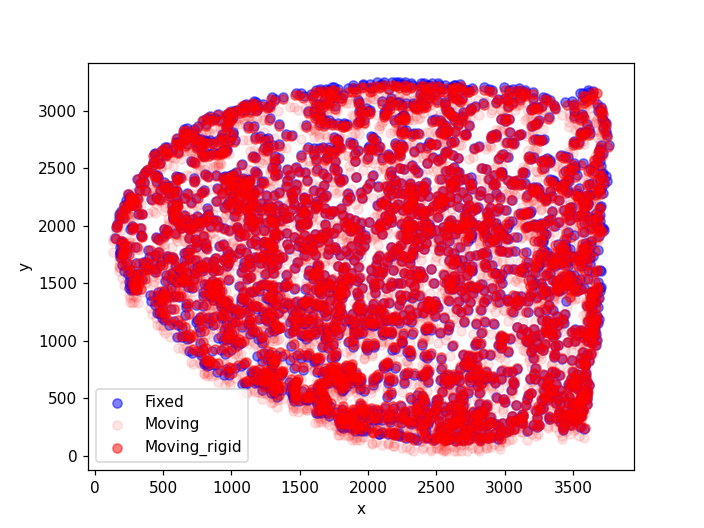

In [193]:
# First do rigid alignment again

plot2d = True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
flattened_arteries_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                           bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                            bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r2.npy'), #r2 anchors
                           bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new_filtered.npy')] # detected eps
flattened_arteries_paths2 = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                            bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                             bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy'), #r2 anchors
                            bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')] #detected eps 
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')

In [194]:
# I/O 

moving_pts_paths = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy'), #r1 anchors
                    bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')] #detected eps 
fixed_pts_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r2.npy'), #r2 anchors
                   bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new_filtered.npy')] # detected eps

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers=8

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_tps_r2.npy')
use_grid_values_path = None

# anchors
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]


##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)


# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 385.361457 seconds
Nonrigid ave. distance [pixels]: 0.002099466559296798
Warping grid...
Warping grid took 198.234735 seconds
Saved grid_values at /mnt/share3/webster/MORF8_3and4/MORF8_3and4/warping_grids/grid_tps_r2.npy
Warping image...


100%|██████████| 1020/1020 [01:41<00:00, 10.01it/s]


Time elapsed: 12.847369 minutes
Loading z 0 - 200


100%|██████████| 200/200 [01:40<00:00,  1.94it/s]


Loading z 200 - 400


100%|██████████| 200/200 [01:40<00:00,  2.25it/s]


Loading z 400 - 564


100%|██████████| 164/164 [01:22<00:00,  1.90it/s]


# Warp all points to new reference frame (r2)
[Return to top](#top)
<a id='warp_points_r2'></a><br>
r0 anchor points (flat --> r2) <br>
ALL detected eps (flat --> r2) < top and bottom> <br>
filtered detected eps (r1) (flat --> r2) (so we can do feature matching again)  <br>
r1 anchor points (flat --> r2)  <br>
r2 anchor points (flat --> r2) <br>


In [195]:
# R2 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_r2frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [196]:
# R1 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_r2frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [197]:
# R0 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_r2frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [198]:
# Filtered ransac matched points: transfrom from flattened frame to r2 frame (moving)
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_r2frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [199]:
# All detected endpoints (moving): transfrom from flattened frame to r1 frame
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_masked_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_masked_r2frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

# Load in R3 manual anchor points

In [201]:
# Load in the new anchor points (combine the old anchor points with the new ones)

json_path = bdir('manual_anchor_labels/r3_labels.json')
new_anchor_pts_moving_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3.npy')
new_anchor_pts_fixed_path = bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r3.npy')
moving_name = 'r3_anchor_R'
fixed_name = 'r3_anchor_L'

##############
moving_pts_new = read_annotations_json(json_path, moving_name, sink_path=new_anchor_pts_moving_path)
fixed_pts_new = read_annotations_json(json_path, fixed_name, sink_path=new_anchor_pts_fixed_path)


# Also save individually in JSON so that we can visualize 
numpy_to_json(fixed_pts_new, new_anchor_pts_fixed_path[:-4]+'.json')
numpy_to_json(moving_pts_new, new_anchor_pts_moving_path[:-4]+'.json')
print(moving_pts_new.shape, fixed_pts_new.shape)

(162, 3) (162, 3)


## Unwarp all of these points (to flattened ref frame)

R2 anchor: r2 anchor --> flat <br>
detected_filtered: R2 anchor --> flat <br>

In [202]:
# R2 anchor points (in the R1 reference frame)
grid_path = bdir('warping_grids/grid_tps_r2.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r2.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3_flatframe.npy')
save_json = False 
inverse_transform = False 


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

## TPS Warp round 3

[Return to top](#top)

### Warp using only anchor points
From the flattened frame

<a id='tpswarp_r3'></a>

(2747, 3) (2747, 3)
204.20691825426061


<IPython.core.display.Javascript object>


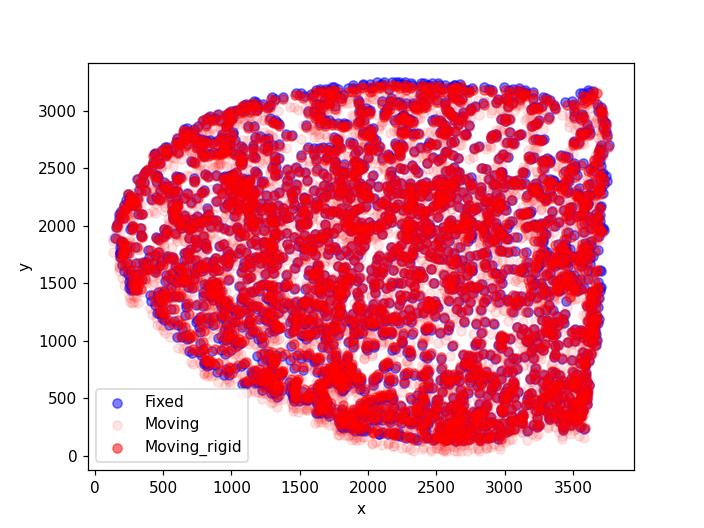

In [204]:
# First do rigid alignment again

plot2d = True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
flattened_arteries_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                           bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                            bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r2.npy'), #r2 anchors
                            bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r3.npy'), #r3 anchors
                           bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new_filtered.npy')] # detected eps
flattened_arteries_paths2 = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                            bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                             bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy'), #r2
                             bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3_flatframe.npy'), #r3
                            bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')] #detected eps 
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')

In [205]:
# I/O 

moving_pts_paths = [bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy'), # r0 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy'), #r1 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy'), #r1 anchors
                    bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3_flatframe.npy'),
                    bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')] #detected eps 
fixed_pts_paths = [bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat.npy'), #r0 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r1.npy'), #r1 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r2.npy'), #r2 anchors
                   bdir('manual_anchor_labels/'+name_prefix+'_anchor_pts_flat_r3.npy'),
                   bdir(name_prefix+'_endpoints_bottom_matched_ransac_r2_new_filtered.npy')] # detected eps

fixed_zarr_path = bdir(name_prefix+'_flattened.zarr')
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')


# Parameters for TPS zarr warp
grid_spacing = 3*(32,)
chunks=3*(200,)
nb_workers=8

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_tps_r3.npy')
use_grid_values_path = None

# anchors
static_pts_paths = [bdir(name_prefix2+'_downsampled_thinsurface_bottom_endpts_contourfiltered_outlier_uv_new.npy')]


##########################

TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path,
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)


# Convert zarr to tiff
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=None)

Fitting radial basis function...
Fitting rbf took 400.585948 seconds
Nonrigid ave. distance [pixels]: 0.002289652329544186
Warping grid...
Warping grid took 201.545625 seconds
Saved grid_values at /mnt/share3/webster/MORF8_3and4/MORF8_3and4/warping_grids/grid_tps_r3.npy
Warping image...


100%|██████████| 1020/1020 [01:36<00:00, 10.55it/s]


Time elapsed: 13.091097 minutes
Loading z 0 - 200


100%|██████████| 200/200 [01:39<00:00,  1.74it/s]


Loading z 200 - 400


100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Loading z 400 - 564


100%|██████████| 164/164 [01:23<00:00,  2.07it/s]


# Warp all points to new reference frame (r3)
[Return to top](#top)
<a id='warp_points_r2'></a><br>
r0 anchor points (flat --> r2) <br>
ALL detected eps (flat --> r2) < top and bottom> <br>
filtered detected eps (r1) (flat --> r2) (so we can do feature matching again)  <br>
r1 anchor points (flat --> r2)  <br>
r2 anchor points (flat --> r2) <br>


In [206]:
# R3 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r3_r3frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [207]:
# R2 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r2_r3frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [208]:
# R1 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat_anchorwarp_r1_r3frame.npy')
save_json = True 
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [209]:
# R0 moving anchor points: transfrom from flattened frame to r2 frame 
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir('manual_anchor_labels/'+name_prefix2+'_anchor_pts_r3frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [210]:
# Filtered ransac matched points: transfrom from flattened frame to r2 frame (moving)
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_flatframe.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_matched_ransac_r2_new_filtered_r3frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)

In [211]:
# All detected endpoints (moving): transfrom from flattened frame to r1 frame
grid_path = bdir('warping_grids/grid_tps_r3.npy')
pts_path = bdir(name_prefix2+'_endpoints_top_masked_flat.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_anchorwarp_r3.zarr')
save_path = bdir(name_prefix2+'_endpoints_top_masked_r3frame.npy')
save_json = True
inverse_transform = True


#####
coords = grid_transform_pts(grid_path, pts_path, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)